### preprocess water discharge data: combine any daily GRDC data into monthly data, convert to csv format 


In [72]:

# Define input and output directories
input_dir = r"C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\unprocessed"
output_dir = r"C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\processed"

# Function to process Q_monthly files
def process_Q_monthly(file_path):
        with open(file_path, 'r', encoding='latin1') as file:
            # Read the file line by line until you find the line that contains "DATA"
            for i, line in enumerate(file):
                if 'lines' in line:
                    # Once "DATA" is found, the number of rows to skip is i+1 (0-indexed)
                    skip_rows = i + 2
                    # Read the CSV file using the dynamically determined number of rows to skip
                    df = pd.read_csv(file_path, skiprows=skip_rows, encoding='latin1', delimiter=';', skipinitialspace=True)
                    df['Original'] = df['Original'].replace(-999.000, pd.NA)
                    df['month'] = pd.to_datetime(df['YYYY-MM-DD']).dt.month
                    df['year'] = pd.to_datetime(df['YYYY-MM-DD']).dt.year
                    df['date'] = df['month'].astype(str) + '/1/' + df['year'].astype(str)
                    df = df.rename(columns={'Original': 'Q'})
                    df_new = df[['date', 'Q']]

        return df_new

# Function to process Q_Day files
def process_Q_day(file_path):
        with open(file_path, 'r', encoding='latin1') as file:
            # Read the file line by line until you find the line that contains "lines"
            for i, line in enumerate(file):
                if 'lines' in line:
                    skip_rows = i + 2
                    df = pd.read_csv(file_path, skiprows=skip_rows, encoding='latin1', delimiter=';', skipinitialspace=True)
                    df['Value'] = df['Value'].replace(-999.000, pd.NA)
                    df['month'] = pd.to_datetime(df['YYYY-MM-DD']).dt.month
                    df['year'] = pd.to_datetime(df['YYYY-MM-DD']).dt.year

                    df_grouped = df.groupby(['year', 'month'])['Value'].mean().reset_index()
                    df_grouped['date'] = df_grouped['month'].astype(str) + '/1/' + df_grouped['year'].astype(str)
                    df_grouped = df_grouped.rename(columns={'Value': 'Q'})
                    df_grouped = df_grouped[['date', 'Q']]
        return df_grouped

# Function to process OHDB files
def process_OHDB(file_path):
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    
    df_grouped = df.groupby(['year', 'month'])['Q'].mean().reset_index()
    df_grouped['date'] = df_grouped['month'].astype(str) + '/1/' + df_grouped['year'].astype(str)
    return df_grouped[['date', 'Q']]

# Iterate over files in the input directory
for file_name in os.listdir(input_dir):
    file_path = os.path.join(input_dir, file_name)
    output_file_path = os.path.join(output_dir, file_name.replace('.txt', '.csv'))
    
    if os.path.exists(output_file_path):
        continue
    
    if file_name.endswith('Q_Month.txt'):
        df = process_Q_monthly(file_path)
        df.to_csv(output_file_path, index=False)
    elif file_name.endswith('Q_Day.txt'):
        df = process_Q_day(file_path)
        df.to_csv(output_file_path, index=False)
    elif file_name.startswith('OHDB'):
        df = process_OHDB(file_path)
        df.to_csv(output_file_path, index=False)
    else:
        continue



### global eBI analysis: from the Galeazzi et al. (2021) dataset

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress

In [3]:
from datetime import datetime

def parse_month_day(month_day_str):
    """Parse 'MM/DD' formatted date strings to (month, day) tuples."""
    month, day = map(int, month_day_str.split('/'))
    return month, day

def is_within_range(date, start_str, end_str):
    """Check if 'date' (a datetime object) is within the range defined by 'start_str' and 'end_str'."""
    start_month, start_day = parse_month_day(start_str)
    end_month, end_day = parse_month_day(end_str)

    # Create (month, day) tuple from the date
    date_month_day = (date.month, date.day)
    
    # Handling year wrap-around
    if (start_month, start_day) > (end_month, end_day):
        # Range wraps to the next year
        return date_month_day >= (start_month, start_day) or date_month_day <= (end_month, end_day)
    else:
        # Normal range within the same year
        return (start_month, start_day) <= date_month_day <= (end_month, end_day)

def classify_river(sinuosity, mean_bi):
    if mean_bi >= 3.5:
        return 'B'  # Multichannels
    elif mean_bi >= 1.4:
        if sinuosity >= 1.4:
            return 'HSW'  # High-sinuosity wandering
        else:
            return 'LSW'  # Low-sinuosity wandering
    else:
        return 'M'  # Single channel


def plot_regression(ax, x, y, color, label, marker, linewidth=5.0):
    # Convert x and y to numpy arrays to avoid index issues
    x = x.values
    y = y.values

    # Sorting the x-values and corresponding y-values
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x_sorted, y_sorted)
    
    # Prepare regression line
    reg_line = slope * x_sorted + intercept
    ax.plot(x_sorted, reg_line, color=color, label=f'{label} (slope: {slope:.2f})', linewidth=linewidth)
    
    # Confidence interval (95% CI)
    ci = 1.96 * std_err * np.sqrt(1/len(x_sorted) + (x_sorted - np.mean(x_sorted))**2 / np.sum((x_sorted - np.mean(x_sorted))**2))
    ax.fill_between(x_sorted, reg_line - ci, reg_line + ci, color=color, alpha=0.2)
    print(f"{label} Slope: {slope:.2f}, Confidence Interval (95%): {ci[0]:.2f} - {ci[-1]:.2f}, R-squared: {r_value**2:.2f}")



#### extracting all stats from rivgraph analysis

In [77]:
# Load Galeazzi dataset 
Galeazzi_file = r"C:\Users\Feifei\Box\BR_remote_sensing\Galeazzi_eBI.csv"
river_df = pd.read_csv(Galeazzi_file)
root_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\ebi_results'
discharge_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\processed'

# Create an empty list to store DataFrames
statistics_dfs = []


# Iterate through each river folder
for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            ebi_csv_path = os.path.join(rivgraph_path, 'eBI_results.csv')
            bi_csv_path = os.path.join(rivgraph_path, 'BI_results.csv')
            # Check if eBI_results.csv exists
            if os.path.exists(ebi_csv_path):
                # Read eBI_results.csv
                ebi_df = pd.read_csv(ebi_csv_path)
                bi_df = pd.read_csv(bi_csv_path)

                # Compute descriptive statistics
                ebi_error = ebi_df.groupby('Year')['eBI'].sem().reset_index(name='ebi_error')
                mean_ebi_error = ebi_error['ebi_error'].mean()
                mean_ebi = ebi_df['eBI'].mean()
                #median_ebi = ebi_df['eBI'].median()
                std_ebi = ebi_df['eBI'].std()
                cov_ebi=std_ebi / mean_ebi
                skew_ebi = ebi_df['eBI'].skew() 
                percentile_95 = np.percentile(ebi_df['eBI'], 95)
                percentile_5 = np.percentile(ebi_df['eBI'], 5)
                ebi_range = percentile_95-percentile_5
                ebi_month = ebi_df.groupby('Month_range')['eBI'].mean().reset_index()
                ebi_grouped = ebi_df.groupby(['Year', 'Month_range'])['eBI'].mean().reset_index()
                median_ebi = ebi_grouped['eBI'].median()
            
                smaller_ebi = min(ebi_month['eBI'].iloc[0], ebi_month['eBI'].iloc[1]) # mean dry month
                larger_ebi = max(ebi_month['eBI'].iloc[0], ebi_month['eBI'].iloc[1]) # mean wet month
                month_diff = smaller_ebi / larger_ebi 

                bi_month = bi_df.groupby('Month_range')['BI'].mean().reset_index()
                smaller_bi = min(bi_month['BI'].iloc[0], bi_month['BI'].iloc[1])
                larger_bi = max(bi_month['BI'].iloc[0], bi_month['BI'].iloc[1])
                mean_low_bi=smaller_bi.mean()
                mean_bi = bi_df['BI'].mean()
                #median_bi = bi_df['BI'].median()
                bi_grouped = bi_df.groupby(['Year', 'Month_range'])['BI'].mean().reset_index()
                median_bi = bi_grouped['BI'].median()


                # Extract variables from Galeazzi file
                galeazzi_row = river_df[river_df['River_Station'] == river_folder].iloc[0]
                qm = galeazzi_row['Qm(m3/s)']
                qmax = galeazzi_row['Qmax(m3/s)']
                qmin = galeazzi_row['Qmin(m3/s)']
                Width = galeazzi_row['Width(m)']
                classification = galeazzi_row['Classification']
                sinuosity = galeazzi_row['Sinuosity']
                sp=galeazzi_row['Stream Power (W/m) ']
                eBI_analysis = galeazzi_row['eBI (N=no, P=potential, Y=yes)?']
                Slope = galeazzi_row['Slope (cm/km) ']
                if pd.notna(galeazzi_row['ID_discharge']):
                    discharge_file = f"{galeazzi_row['ID_discharge']}.csv"
                    discharge_path = os.path.join(discharge_dir, discharge_file)
                    if os.path.exists(discharge_path):
                        discharge_df = pd.read_csv(discharge_path)
                        discharge_df['date'] = pd.to_datetime(discharge_df['date'], format='%m/%d/%Y')

                        # Group the discharge data by Year and Month, then calculate the average discharge for each month
                        discharge_df['Year'] = discharge_df['date'].dt.year
                        discharge_df['Month'] = discharge_df['date'].dt.month
                        monthly_avg_discharge = discharge_df.groupby(['Year', 'Month'])['Q'].mean().reset_index(name='mean_discharge')

                        # Find the month with the highest average discharge (wettest month) and the month with the lowest average discharge (driest month)
                        wettest_month = monthly_avg_discharge.loc[monthly_avg_discharge['mean_discharge'].idxmax()]
                        driest_month = monthly_avg_discharge.loc[monthly_avg_discharge['mean_discharge'].idxmin()]
                        average_wettest_month_discharge = wettest_month['mean_discharge']
                        average_driest_month_discharge = driest_month['mean_discharge']

                        # Calculate DVI_a
                        average_discharge = discharge_df['Q'].mean()
                        DVI_a = (average_wettest_month_discharge - average_driest_month_discharge) / average_discharge if average_discharge != 0 else np.nan
                        
                        # Calculate DVI_c
                        wettest_month_on_record = discharge_df.groupby(discharge_df['date'].dt.month)['Q'].mean().idxmax()
                        driest_month_on_record = discharge_df.groupby(discharge_df['date'].dt.month)['Q'].mean().idxmin()
                        average_wettest_month_on_record_discharge = discharge_df[discharge_df['date'].dt.month == wettest_month_on_record]['Q'].mean()
                        average_driest_month_on_record_discharge = discharge_df[discharge_df['date'].dt.month == driest_month_on_record]['Q'].mean()
                        DVI_c = (average_wettest_month_on_record_discharge - average_driest_month_on_record_discharge) / average_discharge if average_discharge != 0 else np.nan

                        low_flow_range = galeazzi_row['Low flow months']  # "MM/DD-MM/DD"
                        high_flow_range = galeazzi_row['High flow months']

                        # Split the date ranges
                        low_start, low_end = low_flow_range.split('-')
                        high_start, high_end = high_flow_range.split('-')

                        high_flow_mask = discharge_df['date'].apply(lambda x: is_within_range(x, high_start, high_end))
                        high_flow_df = discharge_df[high_flow_mask]
                        mean_high_flow = high_flow_df['Q'].mean()
                        
                        low_flow_mask = discharge_df['date'].apply(lambda x: is_within_range(x, low_start, low_end))
                        low_flow_df = discharge_df[low_flow_mask]
                        mean_low_flow = low_flow_df['Q'].mean()

                        # Filter discharge data
                        mask = discharge_df['date'].apply(lambda x: is_within_range(x, low_start, low_end) or is_within_range(x, high_start, high_end))
                        filtered_discharge_df = discharge_df[mask]
                        
                        clean_discharge_data = filtered_discharge_df['Q'].dropna()
                        
                        # Calculate discharge statistics
                        mean_discharge = clean_discharge_data.mean()
                        std_discharge = clean_discharge_data.std()
                        cov_discharge = std_discharge / mean_discharge if mean_discharge else 0

                        # range_discharge = percentile_5_Q / percentile_95_Q
                        # Create a DataFrame for this river's statistics and variables
                        statistics_df = pd.DataFrame({
                            'River': [river_folder],
                            'ebi_error': [mean_ebi_error],
                            'Mean_eBI': [mean_ebi],
                            'Median_eBI': [median_ebi],
                            'Std_eBI': [std_ebi],
                            'Width(m)': [Width],
                            'Stream Power (W/m) ': [sp],
                            'Coeff_Variation_ebi': [cov_ebi],
                            'Percentile_95': [percentile_95],
                            'Percentile_5': [percentile_5],
                            'eBI_range': [ebi_range],
                            'Skewness_eBI': [skew_ebi],
                            'Month_diff': [month_diff],
                            'smaller_ebi': [smaller_ebi],
                            'larger_ebi': [larger_ebi],
                            'Mean_BI': [mean_bi],
                            'Median_BI': [median_bi],
                            'larger_bi': [larger_bi],
                            'smaller_bi': [smaller_bi],
                            'Qm': [qm],
                            'Qmax': [qmax],
                            'Qmin': [qmin],
                            'Classification': [classification],
                            'Sinuosity': [sinuosity],
                            'Slope (cm/km) ': [Slope],
                            'Cov_Discharge': [cov_discharge],
                            'Mean_High_Flow_Discharge': mean_high_flow,
                            'Mean_Low_Flow_Discharge': mean_low_flow,
                            'DVI_a': [DVI_a],
                            'DVI_c': [DVI_c]

                        })
                        statistics_dfs.append(statistics_df)

# Concatenate all DataFrames into a single DataFrame
statistics_df = pd.concat(statistics_dfs, ignore_index=True)


In [38]:

# Load Galeazzi dataset 
Galeazzi_file = r"C:\Users\Feifei\Box\BR_remote_sensing\Galeazzi_eBI.csv"
river_df = pd.read_csv(Galeazzi_file)
root_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\ebi_results'

# Create an empty list to store DataFrames
statistics_dfs_annual = []

# Iterate through each river folder
for river_folder in os.listdir(root_dir):
    river_path = os.path.join(root_dir, river_folder)
    if os.path.isdir(river_path):
        rivgraph_path = os.path.join(river_path, 'rivgraph')
        if os.path.isdir(rivgraph_path):
            ebi_annual_csv_path = os.path.join(rivgraph_path, 'eBI_results_annual.csv')
            bi_annual_csv_path = os.path.join(rivgraph_path, 'BI_results_annual.csv')
            # Check if eBI_results_annual.csv exists
            if os.path.exists(ebi_annual_csv_path):
                # Read eBI_results_annual.csv
                ebi_annual_df = pd.read_csv(ebi_annual_csv_path)
                bi_annual_df = pd.read_csv(bi_annual_csv_path)

                # Compute descriptive statistics
                ebi_error = ebi_annual_df.groupby('Year')['eBI'].sem().reset_index(name='ebi_error')
                mean_ebi_error = ebi_error['ebi_error'].mean()
                mean_ebi = ebi_annual_df['eBI'].mean()
                median_ebi = ebi_annual_df['eBI'].median()
                std_ebi = ebi_annual_df['eBI'].std()
                cov_ebi = std_ebi / mean_ebi
                skew_ebi = ebi_annual_df['eBI'].skew()
                mean_bi = bi_annual_df['BI'].mean()
                median_bi = bi_annual_df['BI'].median()

                # Extract variables from Galeazzi file
                galeazzi_row = river_df[river_df['River_Station'] == river_folder].iloc[0]
                qm = galeazzi_row['Qm(m3/s)']
                qmax = galeazzi_row['Qmax(m3/s)']
                qmin = galeazzi_row['Qmin(m3/s)']
                Width = galeazzi_row['Width(m)']
                classification = galeazzi_row['Classification']
                sinuosity = galeazzi_row['Sinuosity']
                sp = galeazzi_row['Stream Power (W/m) ']
                Slope = galeazzi_row['Slope (cm/km) ']

                # Create a DataFrame for this river's statistics and variables
                statistics_df_annual = pd.DataFrame({
                    'River': [river_folder],
                    'ebi_error': [mean_ebi_error],
                    'Mean_eBI': [mean_ebi],
                    'Median_eBI': [median_ebi],
                    'Std_eBI': [std_ebi],
                    'Width(m)': [Width],
                    'Stream Power (W/m) ': [sp],
                    'Coeff_Variation_ebi': [cov_ebi],
                    'Percentile_95': [percentile_95],
                    'Percentile_5': [percentile_5],
                    'eBI_range': [ebi_range],
                    'Skewness_eBI': [skew_ebi],
                    'Mean_BI': [mean_bi],
                    'Median_BI': [median_bi],
                    'Qm': [qm],
                    'Qmax': [qmax],
                    'Qmin': [qmin],
                    'Classification': [classification],
                    'Sinuosity': [sinuosity],
                    'Slope (cm/km) ': [Slope],
                })
                statistics_dfs_annual.append(statistics_df_annual)

# Concatenate all DataFrames into a single DataFrame
statistics_df_annual = pd.concat(statistics_dfs_annual, ignore_index=True)


#### plot river global dataset on map

KeyError: 'Classification'

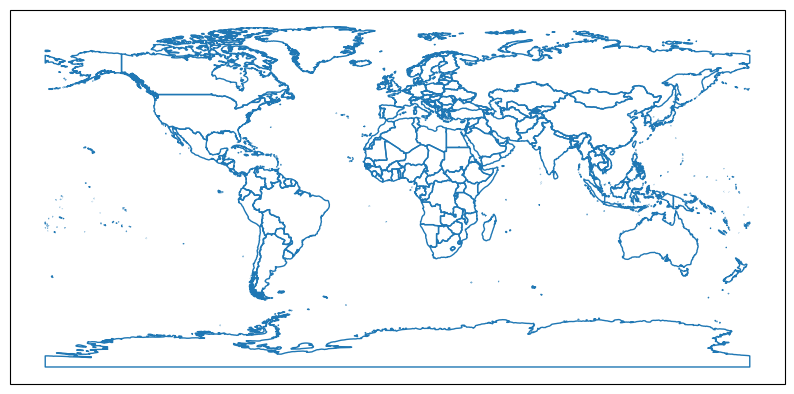

In [79]:
# Load the higher resolution world countries shapefile
world_highres = gpd.read_file(r"C:\Users\Feifei\Box\ne_50m_admin_0_countries\ne_50m_admin_0_countries.shp")

# Assuming river_df and statistics_df are already defined
# Filter rows where eBI/BI is 'Y'
df_filtered = river_df[river_df['eBI/BI'] == 'Y']

df_merged = df_filtered.merge(statistics_df[['River', 'Classification']], left_on='River_Station', right_on='River')

# Define markers and colors for each classification
markers = {'HSW': 's', 'LSW': 'D', 'B': '^'}
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}

# Initialize the plot with the desired projection (Robinson in this case)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.Robinson()})

# Plot the higher resolution world map
world_highres.boundary.plot(ax=ax, linewidth=1)

# Loop through the DataFrame and plot each point with its corresponding marker and color
for index, row in df_merged.iterrows():
    ax.scatter(row['Longitude (deg)'], row['Latitude (deg)'], 
               s=120,  # Size of the marker
               color=colors[row['Classification']],  # Color for the class
               marker=markers[row['Classification']],  # Marker for the class
               edgecolors='black',  # Black outline for each marker
               linewidth=1.5,  # Width of the marker edge
               transform=ccrs.PlateCarree())  # Transformation for the coordinates

# Add a legend
# Create custom labels and handles for the legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='High-Sinuosity Wandering', markerfacecolor='#FFCC00', markersize=10, markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='D', color='w', label='Low-Sinuosity Wandering', markerfacecolor='#FF6666', markersize=10, markeredgewidth=1, markeredgecolor='black'),
    Line2D([0], [0], marker='^', color='w', label='Braided', markerfacecolor='#4169E1', markersize=10, markeredgewidth=1, markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4)

# Remove the axis for a cleaner look
ax.set_global()
ax.coastlines()

plt.show()

#fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\studysites.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)
#fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\studysites.tif", format='tif', dpi=500, bbox_inches='tight')

Number of samples for Braided rivers: 19
Number of samples for HSW rivers: 30
Number of samples for LSW rivers: 48
Braided Slope: 0.85, Confidence Interval (95%): 0.24 - 0.21, R-squared: 0.44
HSW Slope: -0.08, Confidence Interval (95%): 0.12 - 0.21, R-squared: 0.00
LSW Slope: -0.07, Confidence Interval (95%): 0.05 - 0.08, R-squared: 0.01
Braided Slope: 0.52, Confidence Interval (95%): 0.10 - 0.21, R-squared: 0.40
HSW Slope: 0.13, Confidence Interval (95%): 0.07 - 0.13, R-squared: 0.06
LSW Slope: 0.16, Confidence Interval (95%): 0.03 - 0.06, R-squared: 0.11
Braided Slope: 0.06, Confidence Interval (95%): 0.05 - 0.07, R-squared: 0.06
HSW Slope: -0.02, Confidence Interval (95%): 0.01 - 0.03, R-squared: 0.02
LSW Slope: -0.02, Confidence Interval (95%): 0.01 - 0.02, R-squared: 0.06
Braided Slope: 0.05, Confidence Interval (95%): 0.09 - 0.15, R-squared: 0.01
HSW Slope: -0.07, Confidence Interval (95%): 0.03 - 0.05, R-squared: 0.06
LSW Slope: -0.03, Confidence Interval (95%): 0.02 - 0.02, R-s

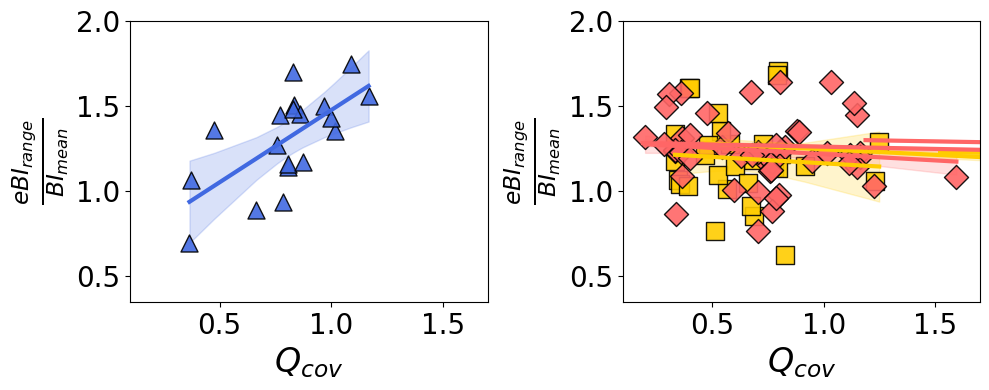

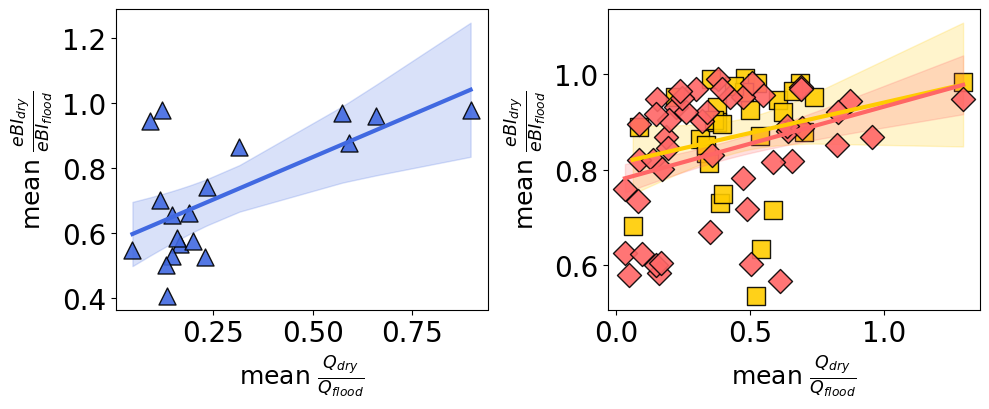

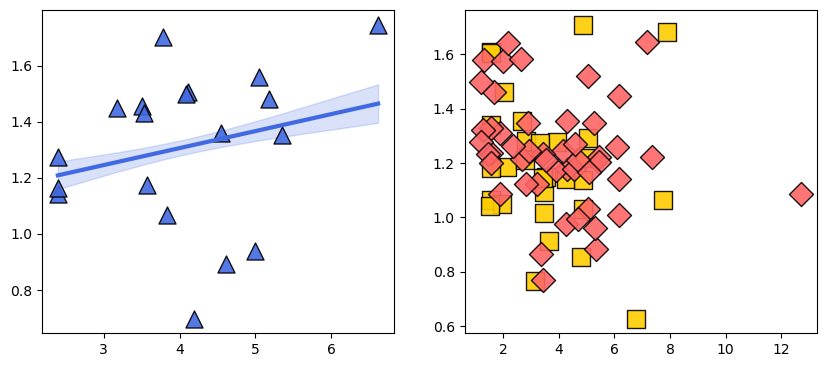

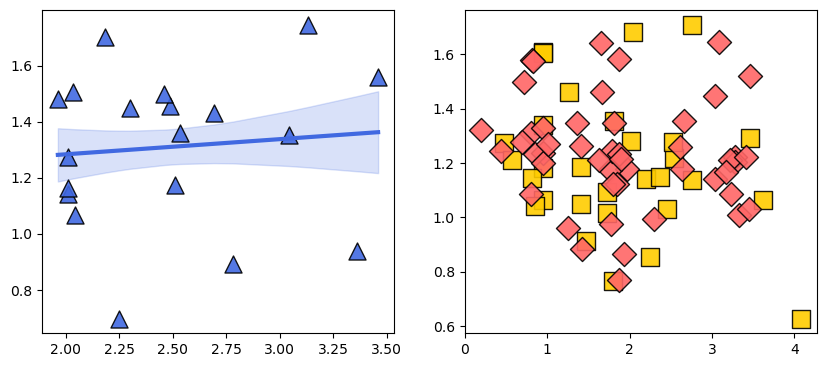

In [80]:
statistics_df['low_high_mean'] = statistics_df['Mean_Low_Flow_Discharge'] / statistics_df['Mean_High_Flow_Discharge']
statistics_df['ebi_range_BI'] = statistics_df['eBI_range'] / statistics_df['Mean_BI']

# Separating braided and wandering rivers
braided_df = statistics_df[statistics_df['Classification'] == 'B']
wandering_df = statistics_df[statistics_df['Classification'].isin(['HSW', 'LSW'])]
# Calculate number of samples for each subset
n_braided = len(braided_df)
n_hsw = len(wandering_df[wandering_df['Classification'] == 'HSW'])
n_lsw = len(wandering_df[wandering_df['Classification'] == 'LSW'])

# Print the number of samples for each plot
print(f'Number of samples for Braided rivers: {n_braided}')
print(f'Number of samples for HSW rivers: {n_hsw}')
print(f'Number of samples for LSW rivers: {n_lsw}')
# Initialize figures and axes for the plots
fig1, (ax1a, ax1b) = plt.subplots(1, 2, figsize=(10, 4))
fig2, (ax2a, ax2b) = plt.subplots(1, 2, figsize=(10, 4.2))
fig3, (ax3a, ax3b) = plt.subplots(1, 2, figsize=(10, 4.2))
fig3, (ax4a, ax4b) = plt.subplots(1, 2, figsize=(10, 4.2))


# Plot settings
markers = {'M': 'o', 'HSW': 's', 'LSW': 'D', 'B': '^'}
colors = {'M': 'purple','HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}

# figure 1: Cov_Discharge vs eBI_range/BI
# braided rivers
plot_regression(ax1a, braided_df['Cov_Discharge'], braided_df['ebi_range_BI'], colors['B'], 'Braided', markers['B'], linewidth=3)
ax1a.scatter(braided_df['Cov_Discharge'], braided_df['ebi_range_BI'], marker=markers['B'], color=colors['B'], edgecolors='black', s=150, alpha=0.9)

for cls in ['HSW', 'LSW']: # HSW and LSW
    cls_df = wandering_df[wandering_df['Classification'] == cls]
    plot_regression(ax1b, cls_df['Cov_Discharge'], cls_df['ebi_range_BI'], colors[cls], cls, markers[cls], linewidth=3)
    ax1b.scatter(cls_df['Cov_Discharge'], cls_df['ebi_range_BI'], marker=markers[cls], color=colors[cls], edgecolors='black', s=150, alpha=0.9)

# figure 2: Mean Dry/Flood Discharge vs Mean Dry/Flood eBI
# braided rivers
plot_regression(ax2a, braided_df['low_high_mean'], braided_df['Month_diff'], colors['B'], 'Braided', markers['B'], linewidth=3)
ax2a.scatter(braided_df['low_high_mean'], braided_df['Month_diff'], marker=markers['B'], color=colors['B'], edgecolors='black', s=150, alpha=0.9)

for cls in ['HSW', 'LSW']:
    cls_df = wandering_df[wandering_df['Classification'] == cls]
    plot_regression(ax2b, cls_df['low_high_mean'], cls_df['Month_diff'], colors[cls], cls, markers[cls], linewidth=3)
    ax2b.scatter(cls_df['low_high_mean'], cls_df['Month_diff'], marker=markers[cls], color=colors[cls], edgecolors='black', s=150, alpha=0.9)

# figure 3: DVI average
plot_regression(ax3a, braided_df['DVI_a'], braided_df['ebi_range_BI'], colors['B'], 'Braided', markers['B'], linewidth=3)
ax3a.scatter(braided_df['DVI_a'], braided_df['ebi_range_BI'], marker=markers['B'], color=colors['B'], edgecolors='black', s=150, alpha=0.9)

for cls in ['HSW', 'LSW']: # HSW and LSW
    cls_df = wandering_df[wandering_df['Classification'] == cls]
    plot_regression(ax1b, cls_df['DVI_a'], cls_df['ebi_range_BI'], colors[cls], cls, markers[cls], linewidth=3)
    ax3b.scatter(cls_df['DVI_a'], cls_df['ebi_range_BI'], marker=markers[cls], color=colors[cls], edgecolors='black', s=150, alpha=0.9)

# figure 4: DVI cumulative
plot_regression(ax4a, braided_df['DVI_c'], braided_df['ebi_range_BI'], colors['B'], 'Braided', markers['B'], linewidth=3)
ax4a.scatter(braided_df['DVI_c'], braided_df['ebi_range_BI'], marker=markers['B'], color=colors['B'], edgecolors='black', s=150, alpha=0.9)

for cls in ['HSW', 'LSW']: # HSW and LSW
    cls_df = wandering_df[wandering_df['Classification'] == cls]
    plot_regression(ax1b, cls_df['DVI_c'], cls_df['ebi_range_BI'], colors[cls], cls, markers[cls], linewidth=3)
    ax4b.scatter(cls_df['DVI_c'], cls_df['ebi_range_BI'], marker=markers[cls], color=colors[cls], edgecolors='black', s=150, alpha=0.9)

# labels
for ax in (ax1a, ax1b):
    ax.set_xlabel(r'${Q_{cov}}$', fontsize=24)
    #ax.set_xlabel('discharge coefficient of variation', fontsize=24)

    ax.set_ylabel(r'$\frac{eBI_{range}}{BI_{mean}}$', fontsize=24)
    ax.set_ylim(0.35, 2)
    ax.set_xlim(0.1, 1.7)

for ax in (ax2a, ax2b):
    ax.set_xlabel(r'mean $\frac{Q_{dry}}{Q_{flood}}$', fontsize=18)
    ax.set_ylabel(r'mean $\frac{eBI_{dry}}{eBI_{flood}}$', fontsize=18)


# Set tick parameters for x and y axis to increase label size
for ax in [ax1a, ax1b, ax2a, ax2b]:
    ax.tick_params(axis='x', labelsize=20)  # Set x-axis tick label size
    ax.tick_params(axis='y', labelsize=20)  # Set y-axis tick label size

fig1.tight_layout()
fig2.tight_layout()

fig1.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\cov_Q.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)
fig2.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\dry_flood_Q.pdf", format='pdf', dpi=500, bbox_inches='tight', transparent=True)
#for i, row in statistics_df.iterrows():
    #ax2.annotate(row['River'], (row['low_high_mean'], row['Month_diff']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

### Channel form index 

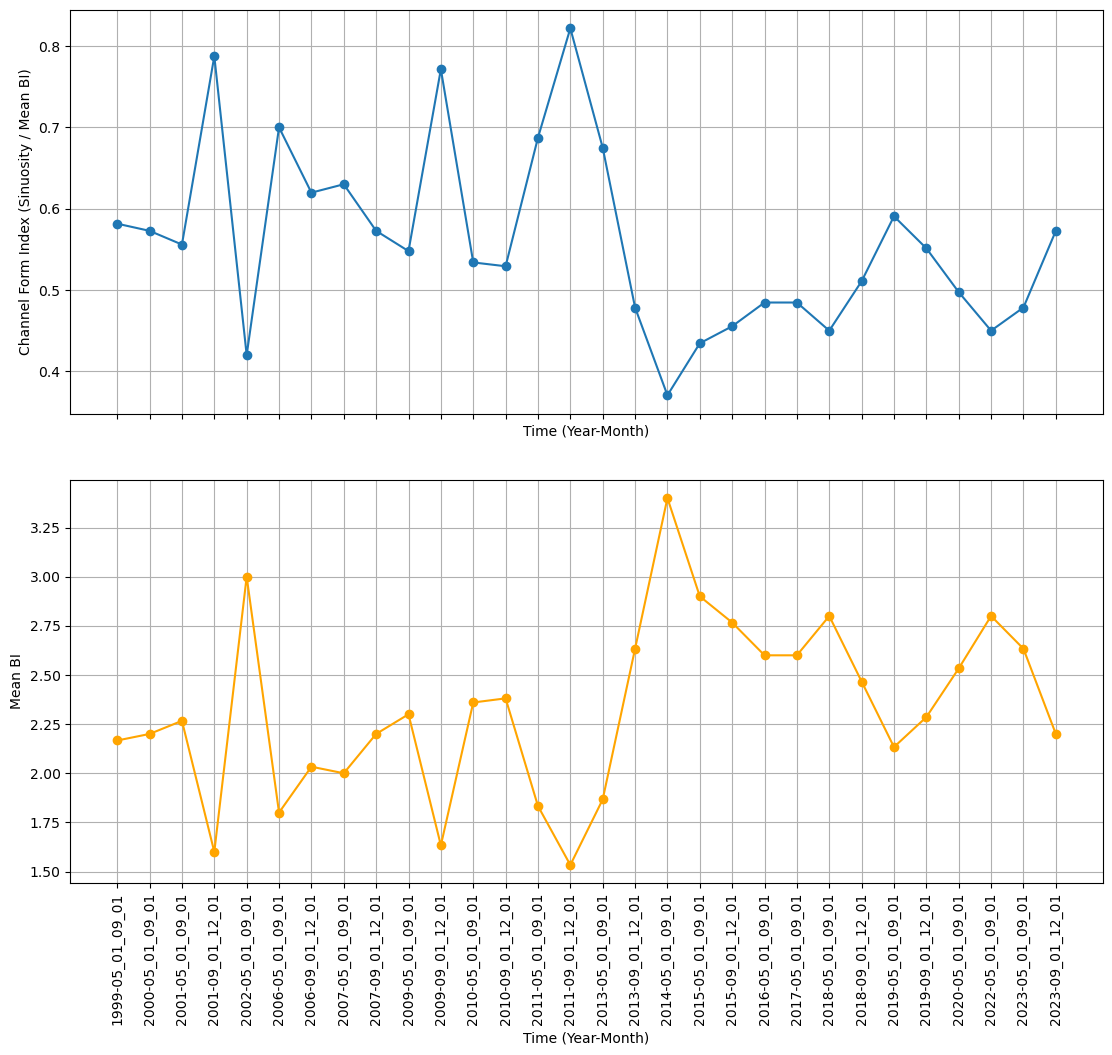

In [20]:
# Load Galeazzi dataset for sinuosity
Galeazzi_file = r"C:\Users\Feifei\Box\BR_remote_sensing\Galeazzi_eBI.csv"
galeazzi_df = pd.read_csv(Galeazzi_file)
sinuosity = galeazzi_df.loc[galeazzi_df['River_Station'] == 'Vilyuy_Khatyryk-Khoma', 'Sinuosity'].values[0]
if pd.notna(sinuosity):
    bi_csv_path = os.path.join(r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results', 'Vilyuy_Khatyryk-Khoma', 'rivgraph', 'BI_results.csv')
    bi_df = pd.read_csv(bi_csv_path)
    bi_monthly_yearly_mean = bi_df.groupby(['Year', 'Month_range'])['BI'].mean().reset_index()
    bi_monthly_yearly_mean['Channel_Form_Index'] = sinuosity / bi_monthly_yearly_mean['BI']
    bi_monthly_yearly_mean['Date_Label'] = bi_monthly_yearly_mean['Year'].astype(str) + '-' + bi_monthly_yearly_mean['Month_range']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    ax1.plot(bi_monthly_yearly_mean['Date_Label'], bi_monthly_yearly_mean['Channel_Form_Index'], marker='o')
    ax1.set_xlabel('Time (Year-Month)')
    ax1.set_ylabel('Channel Form Index (Sinuosity / Mean BI)')
    ax1.grid(True)

    # Plot Mean BI Time Series
    ax2.plot(bi_monthly_yearly_mean['Date_Label'], bi_monthly_yearly_mean['BI'], marker='o', color='orange')
    ax2.set_xlabel('Time (Year-Month)')
    ax2.set_ylabel('Mean BI')
    ax2.grid(True)

    # Improve the spacing between plots
    plt.tight_layout(pad=3.0)
    
    # Rotate x-axis labels for better readability
    for label in ax2.get_xticklabels():
        label.set_rotation(90)
    
    # Show the plot
    plt.show()
else:
    print("Sinuosity value for Yangtze_Datong not found in the dataset.")


#### Qm (mean monthly discharge)

Slope: 1.2495, R-squared: 0.6551
Slope: 0.2823, R-squared: 0.1918
Slope: 0.3560, R-squared: 0.4293
Slope: 1.1406, R-squared: 0.5881
Slope: 0.2893, R-squared: 0.2009
Slope: 0.3095, R-squared: 0.3871


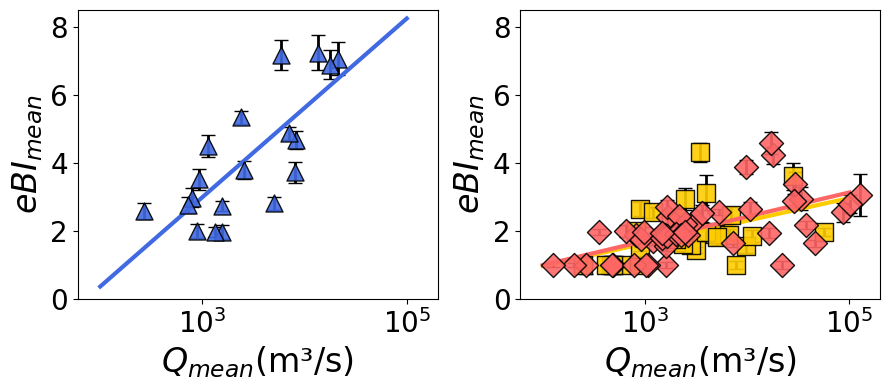

In [26]:
regression_lines = {}
x_range = (1*10**2, 1*10**5)
def fit_regression(x_data, y_data, x_range=x_range):
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value

    if x_range:
        # Use specified x_range for line_x
        line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    else:
        # Use data's range for line_x
        line_x = np.linspace(log_x_data.min(), log_x_data.max(), 300)
    
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, R-squared: {r_squared:.4f}")  # Print slope and R^2
    return np.exp(line_x), line_y

# Calculate regression lines for each classification
for cls in ['B', 'HSW', 'LSW']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Qm']
    y_data = subset['Mean_eBI']
    line_x, line_y= fit_regression(x_data, y_data)
    regression_lines[cls] = {'line_x': line_x, 'line_y': line_y}

# Create the figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Define markers and colors for each planform type
markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}

# Planform type descriptions
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}

# Plot each classification on the appropriate subplot
for cls in ['B']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Qm']
    y_data = subset['Median_eBI']
    line_x, line_y = fit_regression(x_data, y_data)
    error_data = subset['ebi_error']
    
    ax1.plot(line_x, line_y, color=colors[cls], lw=3)
    ax1.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax1.scatter(x_data, y_data, label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9, zorder=2)

for cls in ['HSW', 'LSW']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Qm']
    y_data = subset['Median_eBI']
    line_x, line_y = fit_regression(x_data, y_data)
    error_data = subset['ebi_error']
    
    ax2.plot(line_x, line_y, color=colors[cls], lw=3)
    ax2.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax2.scatter(x_data, y_data, label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9, zorder=2)

# Create custom legends for scatter points
legend_elements = [Line2D([0], [0], marker='s', color='w', label=planform_type[cls],
                          markerfacecolor=colors[cls], markersize=10, markeredgecolor='black') for cls in markers]

# Set log scale for x-axis and labels for axes for both subplots
for ax in (ax1, ax2):
    ax.set_xscale('log')
    ax.set_ylim(bottom=0, top=8.5)
    ax.set_xlim(60, 2e5)
    ax.set_xlabel(r'${Q_{mean}}$(m³/s)', fontsize=24)
    #ax.set_xlabel('mean discharge (m³/s)', fontsize=22)
    ax.set_ylabel(r'${eBI_{mean}}$', fontsize=24)
    ax.tick_params(axis='x', labelsize=20)  # Set x-axis tick label size
    ax.tick_params(axis='y', labelsize=20)  # Set y-axis tick label size

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\Q_eBI_mean.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)


Slope: 1.2504, R-squared: 0.6593
Slope: 0.3169, R-squared: 0.1737
Slope: 0.4212, R-squared: 0.4250


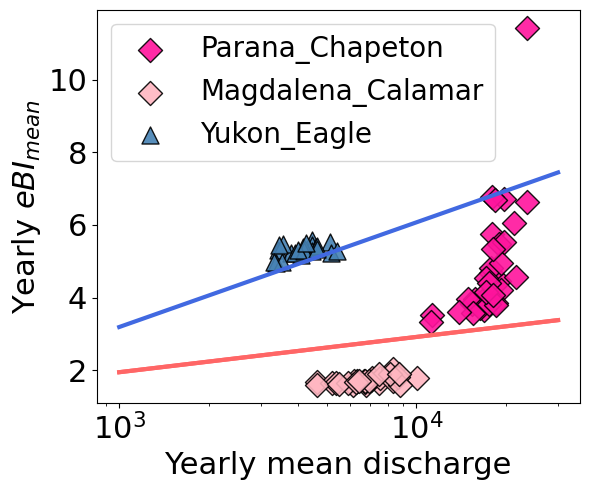

In [294]:
# Load Galeazzi dataset
Galeazzi_file = r"C:\Users\Feifei\Box\BR_remote_sensing\Galeazzi_eBI.csv"
river_df = pd.read_csv(Galeazzi_file)

# Set the directories for eBI and discharge data
root_dir = r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results'
discharge_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\processed'
# Specify the rivers to analyze
rivers_to_analyze = ['Parana_Chapeton', 'Magdalena_Calamar', 'Yukon_Eagle']

# Create a dictionary to store data
yearly_stats = {}

markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}
river_colors = {
    'Parana_Chapeton': '#FF149D', 
    'Magdalena_Calamar': '#FFB6C1', 
    'Yukon_Eagle': '#4682B4'  
}

# Calculate regression lines for each classification
x_range = (10**3, 3*10**4)

for cls in ['B', 'HSW', 'LSW']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Qm']
    y_data = subset['Mean_eBI']
    line_x, line_y= fit_regression(x_data, y_data,  x_range=x_range)
    regression_lines[cls] = {'line_x': line_x, 'line_y': line_y}


for river in rivers_to_analyze:
    # Get the discharge file ID from the Galeazzi dataset
    discharge_id = river_df.loc[river_df['River_Station'] == river, 'ID_discharge'].values[0]
    discharge_file = f"{discharge_id}.csv"
    discharge_path = os.path.join(discharge_dir, discharge_file)

    # Read the discharge data
    discharge_df = pd.read_csv(discharge_path)
    discharge_df['date'] = pd.to_datetime(discharge_df['date'], format='%m/%d/%Y')


    # Get the low and high flow date ranges
    low_flow_range = river_df.loc[river_df['River_Station'] == river, 'Low flow months'].values[0]
    high_flow_range = river_df.loc[river_df['River_Station'] == river, 'High flow months'].values[0]

    # Split the date ranges
    low_start, low_end = low_flow_range.split('-')
    high_start, high_end = high_flow_range.split('-')

    # Filter discharge data based on the ranges
    discharge_df['Year'] = discharge_df['date'].dt.year
    low_flow_mask = discharge_df['date'].apply(lambda x: is_within_range(x, low_start, low_end))
    high_flow_mask = discharge_df['date'].apply(lambda x: is_within_range(x, high_start, high_end))
    
    filtered_discharge_df = discharge_df[low_flow_mask | high_flow_mask]

    # Compute the mean annual discharge
    mean_annual_discharge = filtered_discharge_df.groupby('Year')['Q'].mean().reset_index()

    # Read the eBI data
    ebi_file_path = os.path.join(root_dir, river, 'rivgraph', 'eBI_results.csv')
    ebi_df = pd.read_csv(ebi_file_path)
    mean_annual_ebi = ebi_df.groupby('Year')['eBI'].mean().reset_index()


    # Merge the mean annual eBI and discharge data on 'Year'
    merged_data = pd.merge(mean_annual_ebi, mean_annual_discharge, on='Year', how='inner')
    yearly_stats[river] = merged_data



# Plotting everything in one plot
fig=plt.figure(figsize=(6, 5))
ax = plt.gca()

for river, data in yearly_stats.items():
    classification = river_df.loc[river_df['River_Station'] == river, 'Classification'].values[0]
    ax.scatter(data['Q'], data['eBI'], label=f'{river}', marker=markers[classification], color=river_colors[river], edgecolors='black', s=150, alpha=0.9)
    if classification in regression_lines:
        line_x = regression_lines[classification]['line_x']
        line_y = regression_lines[classification]['line_y']
        # valid_range_mask = (line_x >= 10**3) & (line_x <= 5*10**4)
        ax.plot(line_x, line_y, color=colors[classification], lw=3)

        # ax.plot(line_x, line_y, color=colors[classification], lw=2)
ax.set_xscale('log')
# ax.set_xlabel(r'Yearly ${Q_{mean}}$(m³/s)', fontsize=22)
ax.set_ylabel(r'Yearly ${eBI_{mean}}$',fontsize=22)
ax.set_xlabel('Yearly mean discharge', fontsize=22)
ax.tick_params(axis='y', labelsize=22)  # Set y-axis tick label size
ax.tick_params(axis='x', labelsize=22)  # Set y-axis tick label size
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\Q_eBI_yearly.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)



HSW slope: 0.28
5.501258210544727
LSW slope: 0.36
4.836281906951478
B slope: 1.25
5.583496308781699


Text(0, 0.5, '${eBI_{m}}$')

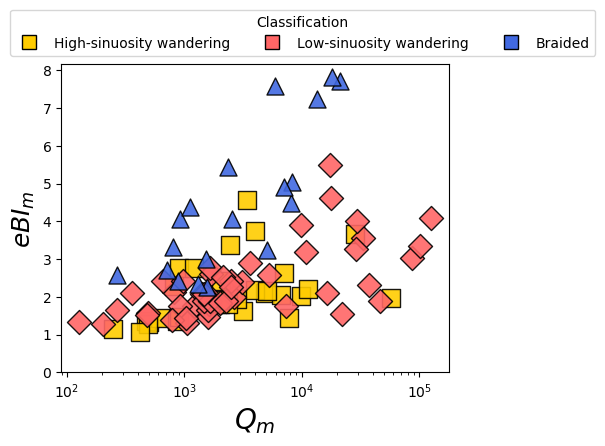

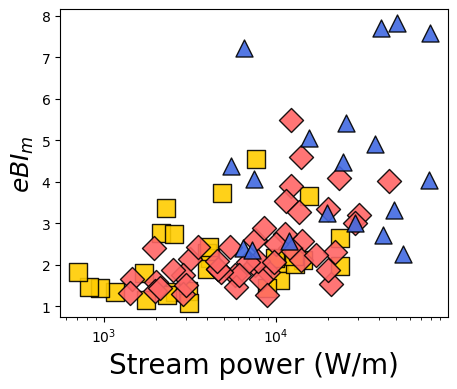

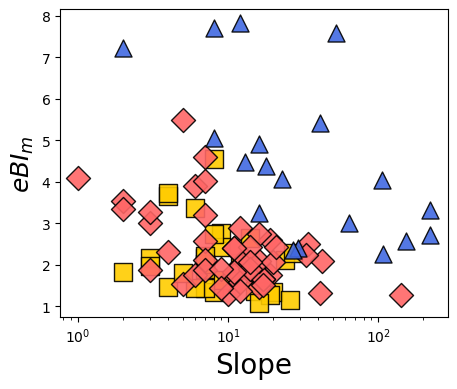

In [59]:
# Function to fit a regression line and return the line's coordinates
def fit_regression_log(x_data, y_data):
    # Apply logarithmic transformation to x_data
    log_x_data = np.log(x_data)
    # Fit the linear regression model
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    print(f"{cls} slope: {slope:.2f}")
    # Create points for the regression line
    line_x = np.linspace(log_x_data.min(), log_x_data.max(), 100)
    print(log_x_data.min())
    line_y = slope * line_x + intercept
    return np.exp(line_x), line_y, std_err  # Transform the line_x back to the original scale

# Create the figure and axis
fig1 = plt.figure(figsize=(5, 4))
ax1 = fig1.add_subplot(111)
fig2 = plt.figure(figsize=(5, 4))
ax2 = fig2.add_subplot(111)
fig3 = plt.figure(figsize=(5, 4))
ax3 = fig3.add_subplot(111)
markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}


for cls in markers:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Qm']
    y_data = subset['Mean_eBI']
    line_x, line_y, std_err = fit_regression_log(x_data, y_data)
    #ax.plot(line_x, line_y, color=colors[cls], lw=2)
    ax1.scatter(statistics_df[statistics_df['Classification'] == cls]['Qm'], 
                   statistics_df[statistics_df['Classification'] == cls]['Mean_eBI'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9) 
    ax2.scatter(statistics_df[statistics_df['Classification'] == cls]['Stream Power (W/m) '], 
                   statistics_df[statistics_df['Classification'] == cls]['Mean_eBI'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9) 
    ax3.scatter(statistics_df[statistics_df['Classification'] == cls]['Slope (cm/km) '], 
                   statistics_df[statistics_df['Classification'] == cls]['Mean_eBI'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9) 
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}

# Create custom legends for scatter points
legend_elements = [Line2D([0], [0], marker='s', color='w', label=planform_type[cls],
                          markerfacecolor=colors[cls], markersize=10, markeredgecolor='black') 
                   for cls in markers]

#Add the custom legends for scatter points
legend=ax1.legend(handles=legend_elements, title='Classification', loc='upper left', ncol=len(markers), bbox_to_anchor=(-0.15,1.2))

# for i, row in statistics_df.iterrows():
#     ax1.annotate(row['River'], (row['Qm'], row['Mean_eBI']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)
#     ax2.annotate(row['River'], (row['Qm'], row['Mean_eBI']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

# Set log scale for x-axis and labels for axes
ax1.set_xscale('log')
ax2.set_xscale('log')
ax3.set_xscale('log')
ax1.set_ylim(bottom=0)
ax1.set_xlabel(r'${Q_{m}}$', fontsize=20)
ax1.set_ylabel(r'${eBI_{m}}$', fontsize=18)
ax2.set_xlabel(r'Stream power (W/m)', fontsize=20)
ax2.set_ylabel(r'${eBI_{m}}$', fontsize=18)
ax3.set_xlabel(r'Slope', fontsize=20)
ax3.set_ylabel(r'${eBI_{m}}$', fontsize=18)

Slope: -0.9182, R-squared: 0.3614
Slope: nan, R-squared: nan
Slope: -0.5468, R-squared: 0.2686
Slope: -0.9182, R-squared: 0.3614
Slope: nan, R-squared: nan
Slope: -0.5468, R-squared: 0.2686


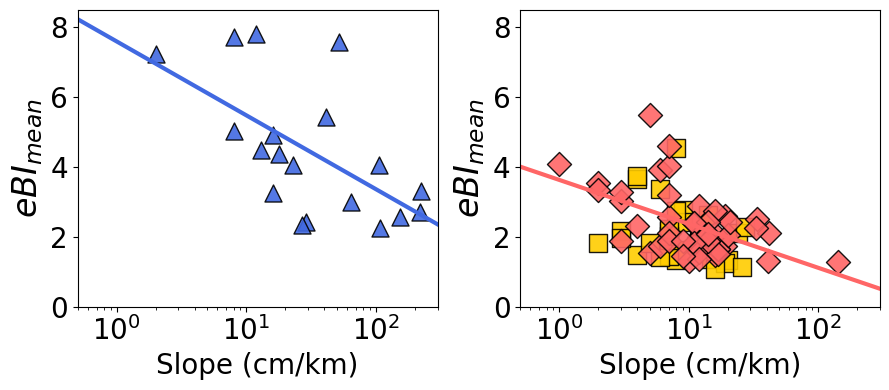

In [162]:
regression_lines = {}
x_range = (0.5, 3*10**2)
def fit_regression(x_data, y_data, x_range=x_range):
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value

    if x_range:
        # Use specified x_range for line_x
        line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    else:
        # Use data's range for line_x
        line_x = np.linspace(log_x_data.min(), log_x_data.max(), 300)
    
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, R-squared: {r_squared:.4f}")  # Print slope and R^2
    return np.exp(line_x), line_y

# Calculate regression lines for each classification
for cls in ['B', 'HSW', 'LSW']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Slope (cm/km) ']
    y_data = subset['Mean_eBI']
    line_x, line_y= fit_regression(x_data, y_data)
    regression_lines[cls] = {'line_x': line_x, 'line_y': line_y}

# Create the figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Define markers and colors for each planform type
markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}

# Planform type descriptions
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}

# Plot each classification on the appropriate subplot
for cls in ['B']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Slope (cm/km) ']
    y_data = subset['Mean_eBI']
    line_x, line_y = fit_regression(x_data, y_data)
    error_data = subset['ebi_error']
    
    ax1.plot(line_x, line_y, color=colors[cls], lw=3)
    #ax1.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax1.scatter(x_data, y_data, label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9)

for cls in ['HSW', 'LSW']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Slope (cm/km) ']
    y_data = subset['Mean_eBI']
    line_x, line_y = fit_regression(x_data, y_data)
    error_data = subset['ebi_error']
    
    ax2.plot(line_x, line_y, color=colors[cls], lw=3)
    #ax2.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax2.scatter(x_data, y_data, label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9)

# Create custom legends for scatter points
legend_elements = [Line2D([0], [0], marker='s', color='w', label=planform_type[cls],
                          markerfacecolor=colors[cls], markersize=10, markeredgecolor='black') for cls in markers]

# Set log scale for x-axis and labels for axes for both subplots
for ax in (ax1, ax2):
    ax.set_xscale('log')
    ax.set_ylim(bottom=0, top=8.5)
    ax.set_xlim(0.5, 3e2)
    ax.set_xlabel(r'Slope (cm/km)', fontsize=20)

    #ax.set_xlabel('mean discharge (m³/s)', fontsize=22)
    ax.set_ylabel(r'${eBI_{mean}}$', fontsize=24)
    ax.tick_params(axis='x', labelsize=20)  # Set x-axis tick label size
    ax.tick_params(axis='y', labelsize=20)  # Set y-axis tick label size

plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\Q_mean_slope.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)


Number of samples for Braided rivers: 19
Number of samples for HSW rivers: 30
Number of samples for LSW rivers: 21


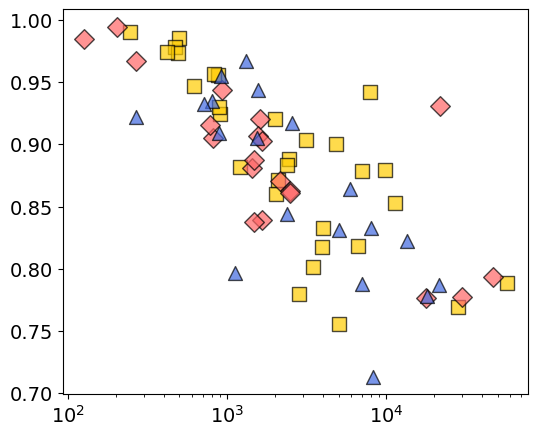

In [70]:
# Separating braided and wandering rivers
braided_df = statistics_df_annual[statistics_df_annual['Classification'] == 'B']
wandering_df = statistics_df_annual[statistics_df_annual['Classification'].isin(['HSW', 'LSW'])]
# Calculate number of samples for each subset
n_braided = len(braided_df)
n_hsw = len(wandering_df[wandering_df['Classification'] == 'HSW'])
n_lsw = len(wandering_df[wandering_df['Classification'] == 'LSW'])

# Print the number of samples for each plot
print(f'Number of samples for Braided rivers: {n_braided}')
print(f'Number of samples for HSW rivers: {n_hsw}')
print(f'Number of samples for LSW rivers: {n_lsw}')

statistics_df_annual['mean_ebi_bi'] = statistics_df_annual['Mean_eBI'] / statistics_df_annual['Mean_BI']
fig1 = plt.figure(figsize=(6, 5))
ax1 = fig1.add_subplot(111)
markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}  
# Fit and plot regression lines for each classification
for cls in markers:
    ax1.scatter(statistics_df_annual[statistics_df_annual['Classification'] == cls]['Qm'], 
                   statistics_df_annual[statistics_df_annual['Classification'] == cls]['mean_ebi_bi'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    
for ax in [ax1]:
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)

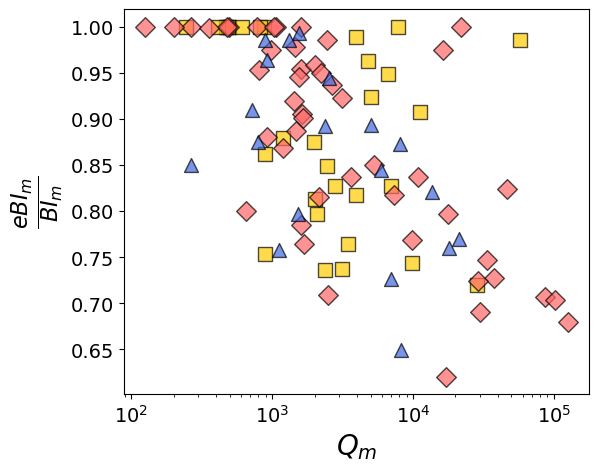

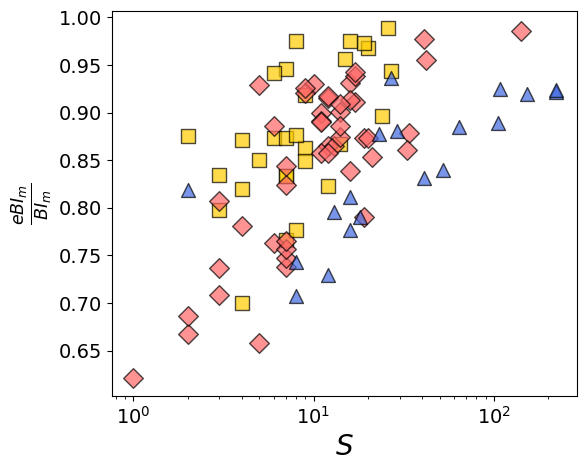

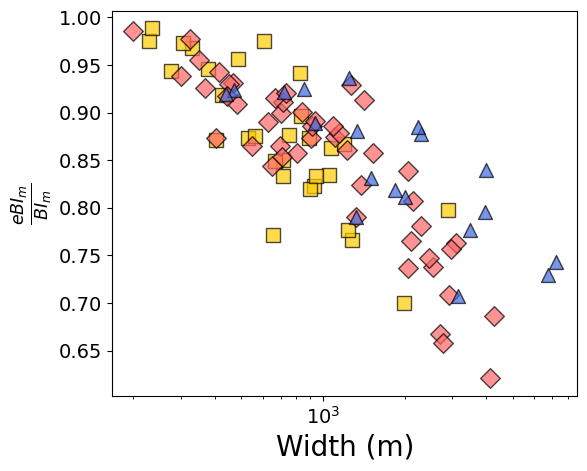

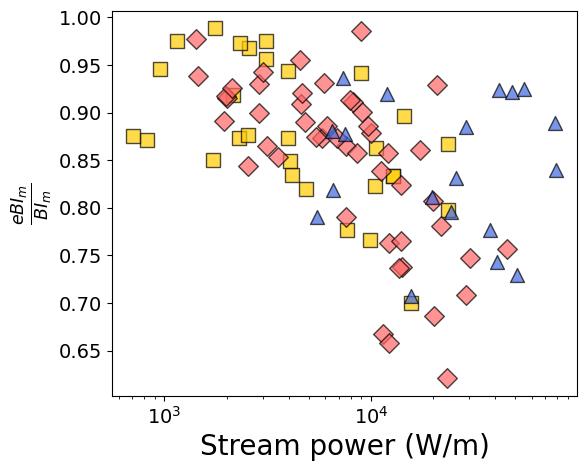

In [71]:
statistics_df['mean_ebi_bi'] = statistics_df['Mean_eBI'] / statistics_df['Mean_BI']
statistics_df['median_ebi_bi'] = statistics_df['Median_eBI'] / statistics_df['Median_BI']

statistics_df['min_ebi_bi'] = statistics_df['smaller_ebi'] / statistics_df['smaller_bi']
statistics_df['max_ebi_bi'] = statistics_df['larger_ebi'] / statistics_df['larger_bi']

fig1 = plt.figure(figsize=(6, 5))
fig2 = plt.figure(figsize=(6, 5))
fig3 = plt.figure(figsize=(6, 5))
fig4 = plt.figure(figsize=(6, 5))

markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}  
ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
ax3 = fig3.add_subplot(111)
ax4 = fig4.add_subplot(111)

def annotate_slope(ax, cls, slope):
    # Annotate slope
    ax.annotate(f'{cls} slope: {slope:.2f}',
                xy=(0.05, 0.95), xycoords='axes fraction', 
                ha='left', va='top', fontsize=10, 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor=colors[cls], facecolor='white'))

# Fit and plot regression lines for each classification
for cls in markers:

    ax1.scatter(statistics_df[statistics_df['Classification'] == cls]['Qm'], 
                   statistics_df[statistics_df['Classification'] == cls]['median_ebi_bi'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax2.scatter(statistics_df[statistics_df['Classification'] == cls]['Slope (cm/km) '], 
                   statistics_df[statistics_df['Classification'] == cls]['mean_ebi_bi'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax3.scatter(statistics_df[statistics_df['Classification'] == cls]['Width(m)'], 
                   statistics_df[statistics_df['Classification'] == cls]['mean_ebi_bi'], 
                   label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax4.scatter(statistics_df[statistics_df['Classification'] == cls]['Stream Power (W/m) '], 
                    statistics_df[statistics_df['Classification'] == cls]['mean_ebi_bi'], 
                    label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers



ax1.set_xlabel(r'${Q_{m}}$', fontsize=20)
ax1.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=23)
ax2.set_xlabel(r'${S}$', fontsize=20)
ax2.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=18)
ax3.set_xlabel(r'Width (m)', fontsize=20)
ax3.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=18)
ax4.set_xlabel(r'Stream power (W/m)', fontsize=20)
ax4.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=18)

planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}

for ax in [ax1, ax2, ax3,ax4]:
    ax.set_xscale('log')
    ax.tick_params(axis='both', which='major', labelsize=14)

# for i, row in statistics_df.iterrows():
#    ax1.annotate(row['River'], (row['Qm'], row['mean_ebi_bi']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)
#     ax2.annotate(row['River'], (row['Qm'], row['mean_ebi_bi']), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}
#legend = ax1.legend(title='Classification', loc='upper left', bbox_to_anchor=(-0.15,1.2), ncol=len(markers), labels=planform_type.values())

plt.show()

#save figure
# fig1.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\mean_eBI_Q.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)
# fig1.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\mean_eBI_Q.tif", format='tif', dpi=500, bbox_inches='tight')
# fig2.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\mean_eBI_BI.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)
# fig2.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\mean_eBI_BI.tif", format='tif', dpi=500, bbox_inches='tight')


Slope: 0.0431, R-squared: 0.5668
Slope: nan, R-squared: nan
Slope: 0.0773, R-squared: 0.5856
Slope: 0.0431, R-squared: 0.5668
Slope: nan, R-squared: nan
Slope: 0.0773, R-squared: 0.5856


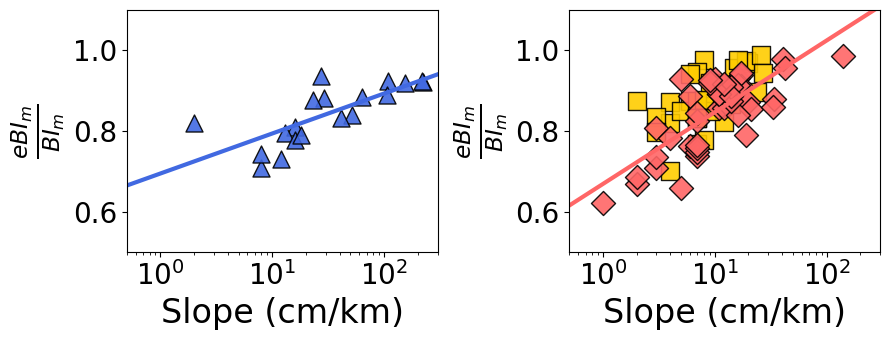

In [173]:
regression_lines = {}
x_range = (0.5, 3*10**2)
def fit_regression(x_data, y_data, x_range=x_range):
    log_x_data = np.log(x_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    r_squared = r_value**2  # Calculate R^2 value

    if x_range:
        # Use specified x_range for line_x
        line_x = np.linspace(np.log(x_range[0]), np.log(x_range[1]), 300)
    else:
        # Use data's range for line_x
        line_x = np.linspace(log_x_data.min(), log_x_data.max(), 300)
    
    line_y = slope * line_x + intercept
    print(f"Slope: {slope:.4f}, R-squared: {r_squared:.4f}")  # Print slope and R^2
    return np.exp(line_x), line_y

# Calculate regression lines for each classification
for cls in ['B', 'HSW', 'LSW']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Slope (cm/km) ']
    y_data = subset['mean_ebi_bi']
    line_x, line_y= fit_regression(x_data, y_data)
    regression_lines[cls] = {'line_x': line_x, 'line_y': line_y}

# Create the figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5))

# Define markers and colors for each planform type
markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}

# Planform type descriptions
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}

# Plot each classification on the appropriate subplot
for cls in ['B']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Slope (cm/km) ']
    y_data = subset['mean_ebi_bi']
    line_x, line_y = fit_regression(x_data, y_data)
    #error_data = subset['ebi_error']
    
    ax1.plot(line_x, line_y, color=colors[cls], lw=3)
    #ax1.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax1.scatter(x_data, y_data, label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9)

for cls in ['HSW', 'LSW']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Slope (cm/km) ']
    y_data = subset['mean_ebi_bi']
    line_x, line_y = fit_regression(x_data, y_data)
    #error_data = subset['ebi_error']
    
    ax2.plot(line_x, line_y, color=colors[cls], lw=3)
    #ax2.errorbar(x_data, y_data, yerr=error_data, fmt='none', ecolor='black', elinewidth=2, capsize=5, zorder=1)
    ax2.scatter(x_data, y_data, label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=150, alpha=0.9)

# Create custom legends for scatter points
legend_elements = [Line2D([0], [0], marker='s', color='w', label=planform_type[cls],
                          markerfacecolor=colors[cls], markersize=10, markeredgecolor='black') for cls in markers]

# Set log scale for x-axis and labels for axes for both subplots
for ax in (ax1, ax2):
    ax.set_xscale('log')
    ax.set_ylim(bottom=0.5, top=1.1)
    ax.set_xlim(0.5, 3e2)
    ax.set_xlabel(r'Slope (cm/km)', fontsize=24)

    #ax.set_xlabel('mean discharge (m³/s)', fontsize=22)
    ax.set_ylabel(r'$\frac{eBI_{m}}{BI_{m}}$', fontsize=24)
    ax.tick_params(axis='x', labelsize=20)  # Set x-axis tick label size
    ax.tick_params(axis='y', labelsize=20)  # Set y-axis tick label size

plt.tight_layout()
plt.show()
fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_ratio_slope.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)



B slope: -0.05, R^2: 0.65
LSW slope: -0.04, R^2: 0.70
HSW slope: -0.04, R^2: 0.61


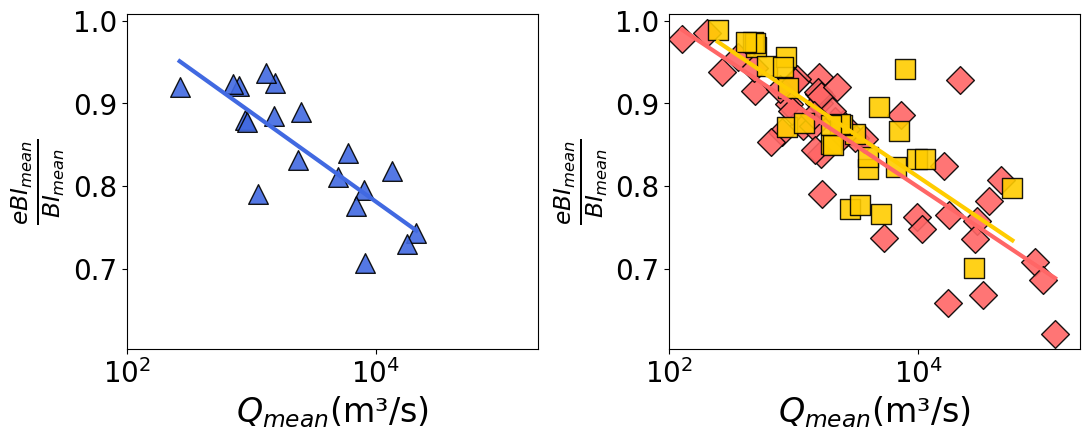

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [29]:
statistics_df['mean_ebi_bi'] = statistics_df['Mean_eBI'] / statistics_df['Mean_BI']
# Define a dictionary to store the regression information
regression_info = {}

def fit_regression_log(x_data, y_data, cls):
    # Apply logarithmic transformation to x_data
    log_x_data = np.log(x_data)
    # Fit the linear regression model
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_x_data, y_data)
    print(f"{cls} slope: {slope:.2f}, R^2: {r_value**2:.2f}")
    # Create points for the regression line
    line_x = np.linspace(log_x_data.min(), log_x_data.max(), 100)
    line_y = slope * line_x + intercept
    # Save regression information for later use
    regression_info[cls] = {
        'line_x': np.exp(line_x),  # Transform back to original scale
        'line_y': line_y,
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'std_err': std_err
    }

# Perform regression analysis and save results
for cls in ['B', 'LSW', 'HSW']:
    subset = statistics_df[statistics_df['Classification'] == cls]
    x_data = subset['Qm']
    y_data = subset['mean_ebi_bi']
    # Perform regression and save the information
    fit_regression_log(x_data, y_data, cls)
# Define new figure for the two subplots
fig, (ax_b, ax_lsw_hsw) = plt.subplots(1, 2, figsize=(11, 4.5), sharey=True)

# Markers and colors as before
markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}

# Plot the regression lines on their respective subplots
ax_b.plot(regression_info['B']['line_x'], regression_info['B']['line_y'], label=f"B Regression",  c=colors['B'], lw=3)
ax_lsw_hsw.plot(regression_info['LSW']['line_x'], regression_info['LSW']['line_y'], label=f"LSW Regression",  c=colors['LSW'], lw=3)
ax_lsw_hsw.plot(regression_info['HSW']['line_x'], regression_info['HSW']['line_y'], label=f"HSW Regression",  c=colors['HSW'], lw=3)


# Fit and plot 'B' rivers in the first subplot
for cls in ['B']:
    ax_b.scatter(statistics_df[statistics_df['Classification'] == cls]['Qm'], 
                 statistics_df[statistics_df['Classification'] == cls]['mean_ebi_bi'], 
                 label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=200, alpha=0.9)

# Fit and plot 'LSW' and 'HSW' rivers in the second subplot
for cls in ['LSW', 'HSW']:
    ax_lsw_hsw.scatter(statistics_df[statistics_df['Classification'] == cls]['Qm'], 
                       statistics_df[statistics_df['Classification'] == cls]['mean_ebi_bi'], 
                       label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=200, alpha=0.9)

# Set the logarithmic scale and labels for the 'B' subplot
ax_b.set_xscale('log')
ax_b.set_xlabel(r'${Q_{mean}}$(m³/s)', fontsize=24)
#ax_b.set_xlabel('mean discharge', fontsize=24)
ax_b.set_ylabel(r'$\frac{eBI_{mean}}{BI_{mean}}$', fontsize=24)
ax_b.tick_params(axis='both', which='major', labelsize=20)
ax_b.set_xlim(1e2, 2e5)

# Set the logarithmic scale and labels for the 'LSW' and 'HSW' subplot
ax_lsw_hsw.set_xscale('log')
ax_lsw_hsw.set_xlabel(r'${Q_{mean}}$(m³/s)', fontsize=24)
#ax_lsw_hsw.set_xlabel('mean discharge', fontsize=24)
ax_lsw_hsw.set_ylabel(r'$\frac{eBI_{mean}}{BI_{mean}}$', fontsize=24)

ax_lsw_hsw.tick_params(axis='both', which='major', labelsize=20)
ax_lsw_hsw.yaxis.set_tick_params(labelleft=True)
ax_lsw_hsw.set_xlim(1e2, 2e5)
plt.tight_layout()
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_BI.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)
fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\eBI_BI.eps", format='eps', dpi=500, bbox_inches='tight', transparent=True)


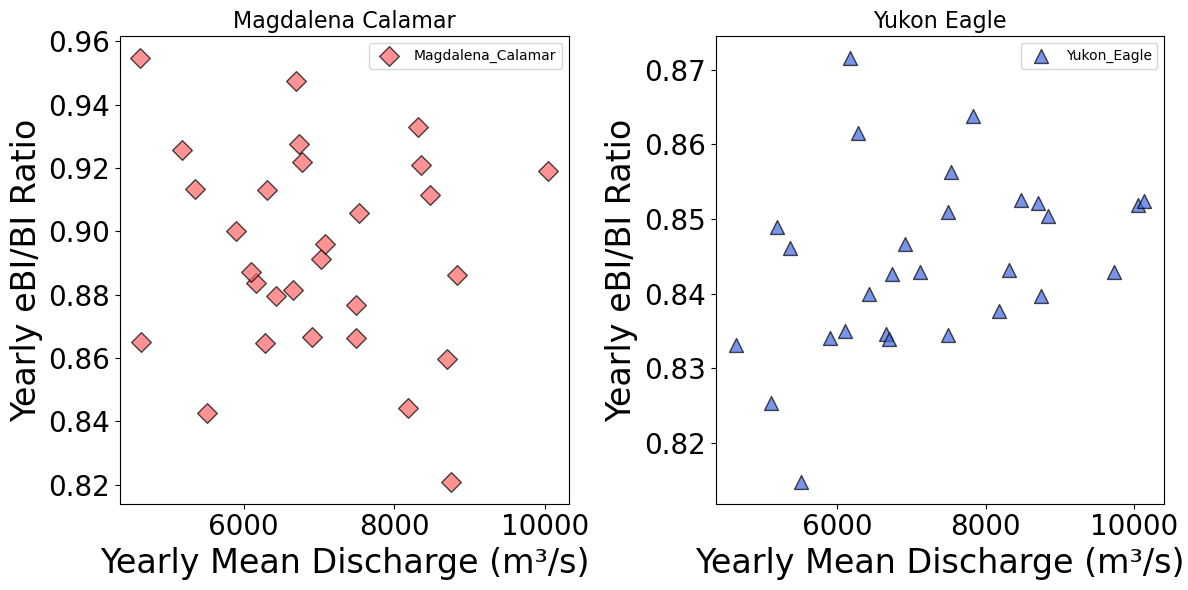

In [325]:


# Define the root directory and subdirectories for eBI and BI results
root_dir = r'C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results'
discharge_dir = r'C:\Users\Feifei\Box\BR_remote_sensing\water_discharge_data\processed'
rivers_to_analyze = ['Magdalena_Calamar', 'Yukon_Eagle']

# Dictionary to hold the final processed data for each river
yearly_stats = {}

for river in rivers_to_analyze:
    # Load eBI and BI results
    ebi_df = pd.read_csv(f"{root_dir}/{river}/rivgraph/eBI_results.csv")
    bi_df = pd.read_csv(f"{root_dir}/{river}/rivgraph/BI_results.csv")
    
    # Calculate mean eBI and mean BI
    mean_ebi = ebi_df.groupby('Year')['eBI'].mean().reset_index().rename(columns={'eBI': 'Mean_eBI'})
    mean_bi = bi_df.groupby('Year')['BI'].mean().reset_index().rename(columns={'BI': 'Mean_BI'})
    
    # Merge mean eBI and mean BI on Year
    merged_df = pd.merge(mean_ebi, mean_bi, on='Year')
    merged_df['eBI_BI_ratio'] = merged_df['Mean_eBI'] / merged_df['Mean_BI']
    
    
    # Merge eBI/BI ratio data with discharge data
    final_data = pd.merge(merged_df, mean_annual_discharge, on='Year')
    yearly_stats[river] = final_data
# Setup plot details
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
markers = {'Magdalena_Calamar': 'D', 'Yukon_Eagle': '^'} 
colors = {'Magdalena_Calamar': '#FF6666', 'Yukon_Eagle': '#4169E1'}  

# Plot data for each river
for ax, (river, data) in zip(axs, yearly_stats.items()):
    ax.scatter(data['Q'], data['eBI_BI_ratio'], label=f'{river}', 
               marker=markers[river], color=colors[river], edgecolors='black', s=100, alpha=0.7)
    ax.set_xlabel('Yearly Mean Discharge (m³/s)', fontsize=24)
    ax.set_ylabel('Yearly eBI/BI Ratio', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_title(river.replace('_', ' '), fontsize=16)


plt.tight_layout()
plt.show()


#### Qmax vs Qm (max monthly vs mean monthly discharge)

In [ ]:
# ratio of Qmax to Qm
statistics_df['Qmax_to_Qm_ratio'] = statistics_df['Qmax'] / statistics_df['Qm']
statistics_df['eBI_max_mean'] = statistics_df['Percentile_95'] / statistics_df['Mean_eBI']

fig1 =plt.figure(figsize=(6, 4))
fig2=plt.figure(figsize=(6, 4))
# fig3=plt.figure(figsize=(6, 4))

ax1 = fig1.add_subplot(111)
ax2 = fig2.add_subplot(111)
# ax3 = fig3.add_subplot(111)

markers = {'HSW': 's', 'LSW': 'D', 'B': '^'} 
colors = {'HSW': '#FFCC00', 'LSW': '#FF6666', 'B': '#4169E1'}  
for cls in markers:
    ax1.scatter(statistics_df[statistics_df['New_Classification'] == cls]['Qmax_to_Qm_ratio'], 
                statistics_df[statistics_df['New_Classification'] == cls]['Mean_eBI'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    ax2.scatter(statistics_df[statistics_df['Classification'] == cls]['Qmax_to_Qm_ratio'], 
                statistics_df[statistics_df['Classification'] == cls]['eBI_max_mean'], 
                label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers
    #ax3.scatter(statistics_df[statistics_df['Classification'] == cls]['Qmax_to_Qm_ratio'], 
                #statistics_df[statistics_df['Classification'] == cls]['mean_ebi_bi'], 
                #label=cls, marker=markers[cls], c=colors[cls], edgecolors='black', s=100, alpha=0.7) # s is size of markers

# Add labels and legend
ax1.set_xlabel(r'$\frac{Q_{max}}{Q_{m}}$', fontsize=20)
ax1.set_ylabel('Mean $\mathit{eBI}$', fontsize=15)
ax2.set_xlabel(r'$\frac{Q_{max}}{Q_{m}}$', fontsize=20)
ax2.set_ylabel(r'$\frac{eBI_{95}}{eBI_{m}}$', fontsize=15)
planform_type = {'HSW': 'High-sinuosity wandering', 'LSW': 'Low-sinuosity wandering', 'B': 'Braided'}
legend = ax1.legend(title='Classification', loc='upper left', bbox_to_anchor=(-0.15,1.2), ncol=len(markers), labels=planform_type.values())
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


### calculating wetted area for two rivers

In [407]:
import os
import cv2
import numpy as np
import csv

def extract_info_from_mask_file(mask_file):
    parts = os.path.splitext(mask_file)[0].split('_')
    river_name = ''
    for part in parts:
        if not part.isdigit():
            river_name += part + '_'
        else:
            break
    river_name = river_name.rstrip('_')
    year = ''
    for part in parts:
        if part.isdigit() and len(part) == 4:
            year = part
            break
    month_parts = []
    for part in parts:
        if part.isdigit() and len(part) == 2:
            month_parts.append(part)
    month_dates_with_underscores = '_'.join(month_parts)
    return river_name, year, month_dates_with_underscores

def calculate_wetted_area(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return 0
    pixel_count = np.sum(mask == 1)
    return pixel_count * 0.0009  # Convert pixel count to area in square km

def process_masks_and_save_results(mask_folder, results_csv_path):
    with open(results_csv_path, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['River', 'Year', 'Month_range', 'wetted area (km2)'])

        for mask_file in os.listdir(mask_folder):
            if mask_file.endswith('.tif'):
                mask_path = os.path.join(mask_folder, mask_file)
                wetted_area = calculate_wetted_area(mask_path)
                
                if wetted_area > 0:
                    river_name, year, month_dates = extract_info_from_mask_file(mask_file)
                    csvwriter.writerow([river_name, year, month_dates, wetted_area])

    print(f"Wetted area calculations are complete and results are saved to {results_csv_path}.")

# Example usage:
mask_folder = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Irrawaddy_Sagaing\output\Irrawaddy_Sagaing\mask"
results_csv_path = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Irrawaddy_Sagaing\rivgraph\wetted_area.csv"

process_masks_and_save_results(mask_folder, results_csv_path)

Wetted area calculations are complete and results are saved to C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Irrawaddy_Sagaing\rivgraph\wetted_area.csv.


In [115]:
def generate_dates(start_year, end_year, month1, month2):
    dates = []
    for year in range(start_year, end_year + 1):
        dates.append(f"{year}-{month1:02d}-01")  # Month1
        dates.append(f"{year}-{month2:02d}-01")  # Month2
    return pd.to_datetime(dates)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


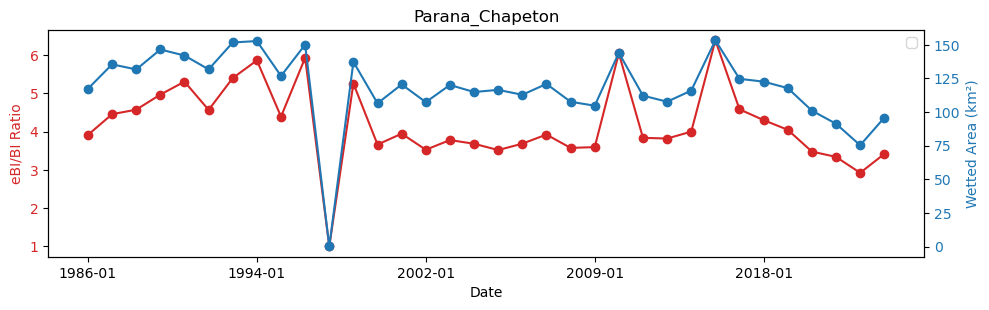

In [352]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# File paths
base_folder = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Parana_Chapeton\rivgraph"
eBI_path = f"{base_folder}\\eBI_results.csv"
BI_path = f"{base_folder}\\BI_results.csv"
wetted_area_path = f"{base_folder}\\wetted_area.csv"

# Read the data
eBI_data = pd.read_csv(eBI_path)
BI_data = pd.read_csv(BI_path)
wetted_area_data = pd.read_csv(wetted_area_path)

# Function to convert Month_range to a date
def conert_month_range(month_range, year):
    first_month = int(month_range[:2])  # Extracts the first two digits only
    date = pd.Timestamp(year=int(year), month=first_month, day=1)
    return date

# Apply the conversion function
eBI_data['Date'] = eBI_data.apply(lambda row: convert_month_range(row['Month_range'], row['Year']), axis=1)
BI_data['Date'] = BI_data.apply(lambda row: convert_month_range(row['Month_range'], row['Year']), axis=1)
wetted_area_data['Date'] = wetted_area_data.apply(lambda row: convert_month_range(row['Month_range'], row['Year']), axis=1)

# Group by Date and calculate means for eBI and BI
eBI_means = eBI_data.groupby('Date')['eBI'].mean().rename('Average_eBI')
BI_means = BI_data.groupby('Date')['BI'].mean().rename('Average_BI')

# No averaging for wetted area, just set the index
wetted_area_total = wetted_area_data.set_index('Date')['wetted area (km2)'].rename('Total_wetted_area')

# Merge the datasets on Date
merged_data = pd.merge(pd.merge(eBI_means, BI_means, left_index=True, right_index=True), 
                       wetted_area_total, left_index=True, right_index=True)
merged_data['eBI_BI_ratio'] = merged_data['Average_eBI']
merged_data.reset_index(inplace=True)  # Reset index to use 'Date' in plotting


custom_dates = generate_dates(1985, 2023, 1, 4)  # Generate dates from 1985 to 2023

# Filter the merged data to only include rows that match the custom_dates
filtered_data = merged_data[merged_data['Date'].isin(custom_dates)].copy()

# Now, we want to plot against the length of the filtered data
x_range = np.arange(filtered_data.shape[0])

# Reset index in the filtered data to align with the x_range
filtered_data.reset_index(drop=True, inplace=True)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 3))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('eBI/BI Ratio', color=color)
ax1.plot(x_range, filtered_data['eBI_BI_ratio'], color=color, label='eBI/BI Ratio', marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Set x-axis ticks and labels to show every 5th date from the filtered dataset
# Determine the positions for every 5th tick
tick_positions = x_range[::7]
# Get the corresponding labels for these positions
tick_labels = [date.strftime('%Y-%m') for i, date in enumerate(filtered_data['Date']) if i in tick_positions]

ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Wetted Area (km²)', color=color)
ax2.plot(x_range, filtered_data['Total_wetted_area'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # Otherwise the right y-label is slightly clipped
plt.title('Parana_Chapeton')
plt.legend()
plt.show()


In [30]:
import calendar

# Define file paths
base_folder = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Parana_Chapeton\rivgraph"
eBI_path = f"{base_folder}\\eBI_results.csv"
wetted_area_path = f"{base_folder}\\wetted_area.csv"

# Irrawaddy
# first_month = 1
# second_month = 6
# Parana
first_month=5
second_month=1

# Read data
eBI_data = pd.read_csv(eBI_path)
wetted_area_data = pd.read_csv(wetted_area_path)

# Function to convert Month_range to a date
def convert_month_range(month_range, year):
    month = int(month_range[:2])  # Extracts the first two digits only
    date = pd.Timestamp(year=int(year), month=month, day=1)
    return date

eBI_data['Date'] = eBI_data.apply(lambda row: convert_month_range(row['Month_range'], row['Year']), axis=1)
wetted_area_data['Date'] = wetted_area_data.apply(lambda row: convert_month_range(row['Month_range'], row['Year']), axis=1)

# Generate custom dates for filtering (assuming this function is defined)
custom_dates = generate_dates(1985, 2023, second_month, first_month)
eBI_filtered = eBI_data[eBI_data['Date'].isin(custom_dates)]
wetted_area_filtered = wetted_area_data[wetted_area_data['Date'].isin(custom_dates)]

eBI_monthly_avg = eBI_filtered.groupby([eBI_filtered['Date'].dt.year, eBI_filtered['Date'].dt.month])['eBI'].mean().unstack()
wetted_area_monthly_avg = wetted_area_filtered.groupby([wetted_area_filtered['Date'].dt.year, wetted_area_filtered['Date'].dt.month])['wetted area (km2)'].mean().unstack()
# Remove the first four data points for June
# Check if June exists in the columns and has enough data to remove
if 6 in eBI_monthly_avg.columns and len(eBI_monthly_avg[6]) > 4:
    eBI_monthly_avg[6] = eBI_monthly_avg[6].drop(eBI_monthly_avg[6].index[:6])

if 6 in wetted_area_monthly_avg.columns and len(wetted_area_monthly_avg[6]) > 4:
    wetted_area_monthly_avg[6] = wetted_area_monthly_avg[6].drop(wetted_area_monthly_avg[6].index[:6])

# Plotting code continues
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 5), sharex=True)

# Get month names
first_month_name = calendar.month_name[first_month]
second_month_name = calendar.month_name[second_month]

# Plot eBI for the specified months if available
for month, month_name in zip([first_month, second_month], [first_month_name, second_month_name]):
    if month in eBI_monthly_avg.columns:
        valid_eBI = eBI_monthly_avg[month].dropna()
        ax1.plot(valid_eBI.index, valid_eBI, label=f'{month_name}', marker='D', linestyle='-', color='tab:blue' if month == first_month else 'tab:red', markersize=10, linewidth=2)

# Plot wetted area for the specified months if available
for month, month_name in zip([first_month, second_month], [first_month_name, second_month_name]):
    if month in wetted_area_monthly_avg.columns:
        valid_wetted_area = wetted_area_monthly_avg[month].dropna()
        ax2.plot(valid_wetted_area.index, valid_wetted_area, label=f'{month_name}', marker='D', linestyle='--', color='tab:blue' if month == first_month else 'tab:red', markersize=10, linewidth=2)

# Setting labels and titles
ax1.set_ylabel('Reach-averaged eBI', fontsize=14)
ax1.legend(loc='upper right', fontsize=15)
ax2.set_xlabel('Year', fontsize=20)
ax2.set_ylabel('Wetted Area (km²)', fontsize=15)
ax1.tick_params(axis='y', labelsize=20)  # y-tick labels
ax2.legend(loc='upper right', fontsize=15)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

plt.show()
fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\Parana_time_series.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)



NameError: name 'generate_dates' is not defined

In [6]:
# Define file paths
base_folder = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Parana_Chapeton\rivgraph"
eBI_path = f"{base_folder}\\eBI_results.csv"
wetted_area_path = f"{base_folder}\\wetted_area.csv"

# Parana
first_month = 5
second_month = 1

# Read data
eBI_data = pd.read_csv(eBI_path)

# Function to convert Month_range to a date
def convert_month_range(month_range, year):
    month = int(month_range[:2])  # Extracts the first two digits only
    date = pd.Timestamp(year=int(year), month=month, day=1)
    return date

eBI_data['Date'] = eBI_data.apply(lambda row: convert_month_range(row['Month_range'], row['Year']), axis=1)

# Generate custom dates for filtering (assuming this function is defined)
def generate_dates(start_year, end_year, second_month, first_month):
    dates = []
    for year in range(start_year, end_year + 1):
        dates.append(pd.Timestamp(year=year, month=first_month, day=1))
        dates.append(pd.Timestamp(year=year, month=second_month, day=1))
    return dates

custom_dates = generate_dates(1985, 2023, second_month, first_month)
eBI_filtered = eBI_data[eBI_data['Date'].isin(custom_dates)]

eBI_monthly_avg = eBI_filtered.groupby([eBI_filtered['Date'].dt.year, eBI_filtered['Date'].dt.month])['eBI'].mean().unstack()

# Filter data for specified cross sections
cross_sections = [6, 43]
eBI_yearly_avg = filtered_eBI_data.groupby(['Year', 'Cross_section'])['eBI'].mean().unstack()

# Create the figure and axes for subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 5), sharex=True)

# Get month names
first_month_name = calendar.month_name[first_month]
second_month_name = calendar.month_name[second_month]

# Plot eBI for the specified months if available
for month, month_name in zip([first_month, second_month], [first_month_name, second_month_name]):
    if month in eBI_monthly_avg.columns:
        valid_eBI = eBI_monthly_avg[month].dropna()
        ax1.plot(valid_eBI.index, valid_eBI, label=f'{month_name}', marker='o', linestyle='-', color='tab:blue' if month == first_month else 'tab:red', markersize=10, linewidth=2)

# Plot yearly average eBI for each cross-section
colors = {6: 'tab:blue', 43: 'tab:red'}
linestyles = {6: '-', 43: '-'}

for cross_section in cross_sections:
    ax2.plot(eBI_yearly_avg.index, eBI_yearly_avg[cross_section], label=f'Cross section {cross_section}', marker='D', linestyle=linestyles[cross_section], color=colors[cross_section], markersize=10, linewidth=2)

# Setting labels and titles
ax1.set_ylabel('Reach-averaged eBI', fontsize=14)
ax1.legend(loc='upper right', fontsize=15)
ax2.set_xlabel('Year', fontsize=20)
ax2.set_ylabel('Yearly average eBI', fontsize=15)
ax1.tick_params(axis='y', labelsize=20)  # y-tick labels
ax2.legend(loc='upper right', fontsize=15)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\Parana_time_series.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)


NameError: name 'filtered_eBI_data' is not defined

### rivers draining out of HMA showing increase in eBI

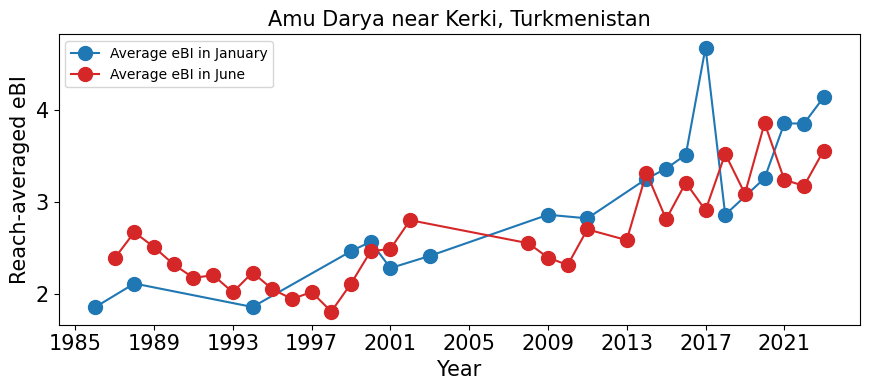

In [13]:

base_folder = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\AmuDarya_Kerki\rivgraph"
eBI_path = f"{base_folder}\\eBI_results.csv"
eBI_data = pd.read_csv(eBI_path)
eBI_data['Date'] = eBI_data.apply(lambda row: convert_month_range(row['Month_range'], row['Year']), axis=1)
# Filter the eBI data to only include rows that match the custom_dates
custom_dates = generate_dates(1985, 2023, 1, 6)  # Assuming this function is defined as before
# Filter the eBI data to include only rows with the custom dates
eBI_filtered = eBI_data[eBI_data['Date'].isin(custom_dates)]

# Calculate the average eBI for the specified months across years
eBI_monthly_avg = eBI_filtered.groupby([eBI_filtered['Date'].dt.year, eBI_filtered['Date'].dt.month])['eBI'].mean().unstack()

# Reindex the DataFrame to include all years, which will fill missing years with NaN
all_years = np.arange(1985, 2023 + 1)
eBI_monthly_avg = eBI_monthly_avg.reindex(all_years)

# Plotting
fig, ax = plt.subplots(figsize=(9, 4))


# Check if the month exists in the columns and plot, this will avoid KeyError
if 1 in eBI_monthly_avg.columns:
    # Drop NaN values for a clean plot without breaks
    eBI_monthly_avg_no_nan_jan = eBI_monthly_avg[1].dropna()
    ax.plot(eBI_monthly_avg_no_nan_jan.index, eBI_monthly_avg_no_nan_jan, label='Average eBI in January', marker='o', linestyle='-', color='tab:blue', markersize=10)

if 6 in eBI_monthly_avg.columns:
    # Drop NaN values for a clean plot without breaks
    eBI_monthly_avg_no_nan_jun = eBI_monthly_avg[6].dropna()
    ax.plot(eBI_monthly_avg_no_nan_jun.index, eBI_monthly_avg_no_nan_jun, label='Average eBI in June', marker='o', linestyle='-', color='tab:red', markersize=10)

year_ticks = all_years[::4]  # Select every 4th year for x-ticks
ax.set_xticks(year_ticks)  # Set these years as the x-ticks
ax.set_xticklabels(year_ticks)  # Set the labels
ax.tick_params(axis='x', labelsize=15)  # y-tick labels
ax.tick_params(axis='y', labelsize=15)  # y-tick labels

# Set labels and title
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Reach-averaged eBI', fontsize=15)
plt.title('Amu Darya near Kerki, Turkmenistan', fontsize=15)

# Add legend and show plot
plt.legend()
plt.tight_layout()  # Adjust layout to fit
plt.show()

Regression Slope: 0.08, Confidence Interval (95%): 0.02 - 0.02, R-squared: 0.10


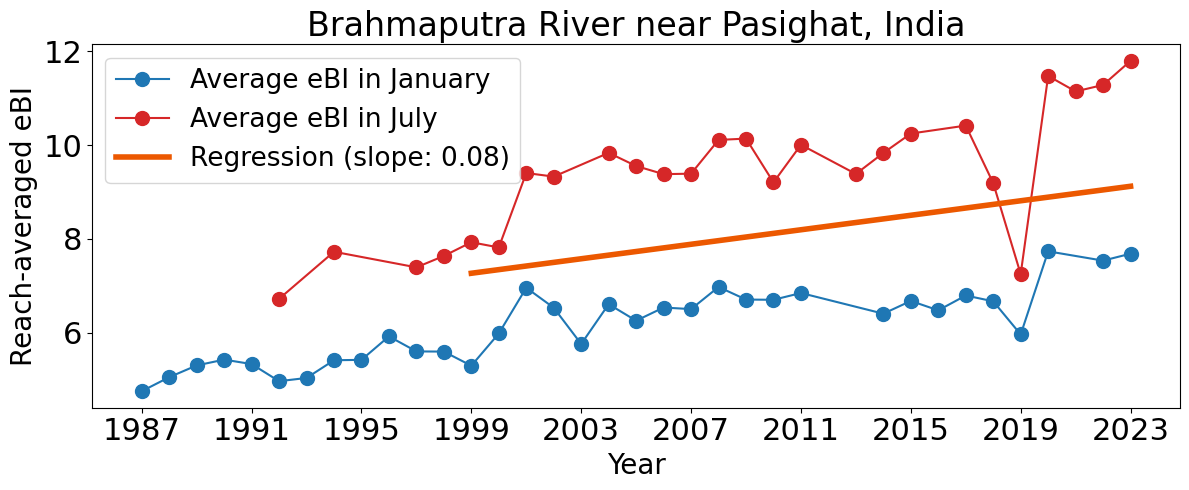

In [177]:
# Load eBI data
base_folder = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\Brahmaputra_Pasighat\rivgraph"
eBI_path = f"{base_folder}\\eBI_results.csv"
eBI_data = pd.read_csv(eBI_path)
eBI_data['Date'] = pd.to_datetime(eBI_data.apply(lambda row: convert_month_range(row['Month_range'], row['Year']), axis=1))

# Calculate the average eBI for specified months across all years
eBI_monthly_avg = eBI_data.groupby([eBI_data['Date'].dt.year, eBI_data['Date'].dt.month])['eBI'].mean().unstack()

# Plotting
fig, ax = plt.subplots(figsize=(12,5))

# Plot data for all available years
months_of_interest = [1, 7]  # January and July
for month in months_of_interest:
    if month in eBI_monthly_avg.columns:
        monthly_data = eBI_monthly_avg[month].dropna()
        ax.plot(monthly_data.index, monthly_data, label=f'Average eBI in {"January" if month == 1 else "July"}',
                marker='o', linestyle='-', color='tab:blue' if month == 1 else 'tab:red', markersize=10)

# Filter data for regression (since 1999)
data_for_regression = []
for month in months_of_interest:
    if month in eBI_monthly_avg.columns:
        monthly_data = eBI_monthly_avg[month].dropna()
        # Select data from 1999 onwards
        filtered_data = monthly_data[monthly_data.index >= 1999]
        data_for_regression.append(pd.DataFrame({'Year': filtered_data.index, 'eBI': filtered_data}))

# Concatenate data from both months for regression analysis
all_data = pd.concat(data_for_regression)
all_data = all_data.dropna()  # Ensure there are no NaN values

# Call plot_regression to plot the regression line and confidence intervals
plot_regression(ax, all_data['Year'], all_data['eBI'], color='#EC5800', label='Regression', marker='o', linewidth=4)

# Further plot settings
year_ticks = np.arange(min(eBI_monthly_avg.index), max(eBI_monthly_avg.index) + 1, 4)  # Generate year ticks from the full range
ax.set_xticks(year_ticks)  # Set these years as the x-ticks
ax.set_xticklabels(year_ticks)  # Set the labels
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Reach-averaged eBI', fontsize=20)
ax.tick_params(axis='x', labelsize= 22)
ax.tick_params(axis='y', labelsize=22)
plt.title('Brahmaputra River near Pasighat, India', fontsize=24)
plt.legend(fontsize=19)
plt.tight_layout()  # Adjust layout to fit
plt.show()
fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\Brahmaputra_HMA.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)


Regression Slope: 0.06, Confidence Interval (95%): 0.01 - 0.00, R-squared: 0.59


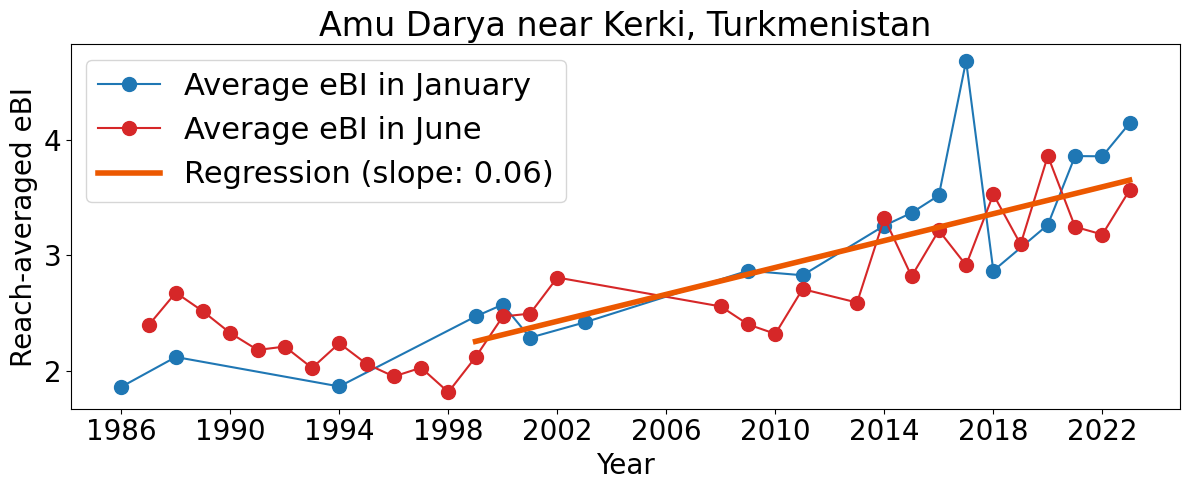

In [178]:
# Load eBI data
base_folder = r"C:\Users\Feifei\PHD\Landsat_watermasks\ebi_results\AmuDarya_Kerki\rivgraph"
eBI_path = f"{base_folder}\\eBI_results.csv"
eBI_data = pd.read_csv(eBI_path)
eBI_data['Date'] = pd.to_datetime(eBI_data.apply(lambda row: convert_month_range(row['Month_range'], row['Year']), axis=1))

# Calculate the average eBI for specified months across all years
eBI_monthly_avg = eBI_data.groupby([eBI_data['Date'].dt.year, eBI_data['Date'].dt.month])['eBI'].mean().unstack()

# Plotting
fig, ax = plt.subplots(figsize=(12, 5))

# Plot data for all available years
months_of_interest = [1, 6]  # January and July
for month in months_of_interest:
    if month in eBI_monthly_avg.columns:
        monthly_data = eBI_monthly_avg[month].dropna()
        ax.plot(monthly_data.index, monthly_data, label=f'Average eBI in {"January" if month == 1 else "June"}',
                marker='o', linestyle='-', color='tab:blue' if month == 1 else 'tab:red', markersize=10)

# Filter data for regression (since 1999)
data_for_regression = []
for month in months_of_interest:
    if month in eBI_monthly_avg.columns:
        monthly_data = eBI_monthly_avg[month].dropna()
        # Select data from 1999 onwards
        filtered_data = monthly_data[monthly_data.index >= 1999]
        data_for_regression.append(pd.DataFrame({'Year': filtered_data.index, 'eBI': filtered_data}))

# Concatenate data from both months for regression analysis
all_data = pd.concat(data_for_regression)
all_data = all_data.dropna()  # Ensure there are no NaN values

# Call plot_regression to plot the regression line and confidence intervals
plot_regression(ax, all_data['Year'], all_data['eBI'], color='#EC5800', label='Regression', marker='o', linewidth=4)
# Further plot settings
year_ticks = np.arange(min(eBI_monthly_avg.index), max(eBI_monthly_avg.index) + 1, 4)  # Generate year ticks from the full range
ax.set_xticks(year_ticks)  # Set these years as the x-ticks
ax.set_xticklabels(year_ticks)  # Set the labels
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Reach-averaged eBI', fontsize=20)
ax.tick_params(axis='x', labelsize= 20)
ax.tick_params(axis='y', labelsize=20)
plt.title('Amu Darya near Kerki, Turkmenistan', fontsize=24)
plt.legend(fontsize=22)
plt.tight_layout()  # Adjust layout to fit
plt.show()

fig.savefig(r"C:\Users\Feifei\Box\BR_remote_sensing\figures\AmuDarya_HMA.pdf", format='pdf',dpi=500, bbox_inches='tight',transparent=True)
